# Project: Build a Traffic Sign Recognition Classifier with 98% Accuracy

![icon_image](./images/softmax_probability.png)

This project presents a deep learning architecture that can identify traffic signs with close to 98% accuracy on the test set. We start from building a simple CNN model, and later on apply different image processing techniques such as Grayscale Conversion, Normalisation, Histogram Equalization and Data Augmentation to see how they can enhance the model's performance. Along the way, we also try out several Dropout values to imporove the model's accuracy on test set.


The project is divided into three parts. In the first part, we explore and get a summarization of the input dataset. The second part focuses on designing and testing the model architecture using different CNN configurations, Dropout Values and Image Processing techniques. In the final section, we test the most outstanding model on the new images and analyze the prediction performance.

# Table of contents
I. [**Load and Explore the Dataset**](#1)
1. [**Load the data**](#2)
2. [**Dataset Summary and Exploration**](#3)
    * [Group images by classes](#4)
    * [Training Set](#5)
        - [Group images in Training set](#6)
        - [Training Set Distribution Visualization](#7)
        - [Training Set Image Visualization](#8)
    * [Validation Set](#9)
        - [Group Images in Validatation Set](#10)
        - [Validation Set Distribution Visualization](#11)
        - [Validation Set Images Visualization](#12)
        
3. [**Create a Sample Set**](#13)

II. [**Design and Test a Model Architecture**](#14)
1. [**Data Pre-Processing**](#15)
    * [Normalisation](#16)
    * [Grayscale](#17)
2. [**Model Architectures**](#18)
    * [Configuration and Execution pipeline ](#19)
    * [EdLe Net](#20)
3. [**Train, Validate and Test the Model**](#21)
    * [Non Normalised images](#22)
        - [Color Sample Dataset](#23)
        - [Color Full Dataset](#24)
        - [Grayscale Full Dataset](#25)
    * [Normalised images](#26)
        - [Color (Normalised )](#27)
        - [Grayscale (Normalised)](#28)
    * [Dropout - Keep 75% of weights in Fully Connected Layers](#29)
        - [Color (Normalised)](#30)
        - [Grayscale (Normalised) ](#31)
    * [Dropout - Keep 50% of weights in Fully Connected Layers](#32)
        - [Grayscale (Normalised)](#33)
        - [Color (Normalised)](#34)
4.  [**Histogram Equalization**](#35)
    * [Model Evaluation](#36)
        - [Normalise images with No Dropout ](#37)
        - [Normalise images with Dropout ](#38)
    * [Analysis of 3x3 Model performance](#39)
5. [**Data Augmentation**](#40)
    * [Evaluating model on augmented dataset](#41)
        - [Grayscale Augmented Dataset](#42)
        - [No Dropout](#43)
        - [Dropout - Keep Fully Connected Layer Weights with p = 0.5 ](#44)
            - [*TAKE1: dropout (p-conv=0.7, p-fc=0.5)*](#45)
            - [*TAKE2: dropout (p-conv=0.7, p-fc=0.4)*](#46)
            - [*TAKE3: dropout (p-conv=0.6, p-fc=0.5)*](#47)
            - [*TAKE4: dropout (p-conv=0.7, p-fc=0.5) more epochs*](#48)
            
III. [**Test Model on New Images**](#50)
1. [**Load and Output the Images**](#51)
2. [**Predicting the Sign Type for Each Image**](#52)
3. [**Analyze Prediction Performance**](#53)
    * [Calculating accuracy](#54)
    * [Calculating Top 5 Softmax Probabilites](#55)
    * [Visualize Our Softmax Probabilites](#56)
4. [**Visualizing feature maps**](#57)
5. [**Future Improvement**](#58)
        
    
        


In [1]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

In [2]:
# Import crucial modules
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
# from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time

# I. Load and Explore the Dataset <a name="1"></a>
## 1. Load the data <a name="2"></a>

In [3]:
datasets_path = "./datasets/german_traffic_signs/"
models_path = "./models/"

training_file = datasets_path + 'train.p'
validation_file = datasets_path + 'valid.p'
testing_file = datasets_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


## 2. Dataset Exploration and Summary <a name="3"></a>
The pickled data is a dictionary with 4 key/value pairs:

   * 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
   * 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
   * 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
   * 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [4]:
# Let's get some dimensions
print("Features shape: ", X_train.shape)
print("Labels shape: ", y_train.shape)

Features shape:  (34799, 32, 32, 3)
Labels shape:  (34799,)


In [5]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validatation examples
n_validation = X_valid.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# What's the shape of an traffic sign image
image_shape = X_train.shape[1:]

# How many unique classes/labels in the datasets
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Group images by classes <a name="4"></a>
We leverage on the pandas module to group the images by label. Our first step is to import the signnames.csv file which contains English description of the labels.

In [6]:
# Load the sign names file
sign_names = pd.read_csv("signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=5)

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

### Training Set <a name="5"></a>
#### Group images in Training set <a name="6"></a>

In [7]:
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)

# print those mappings
X_train_id_to_label.head(n=5)

img_id  label_id         label_name
0       0        41  End of no passing
1       1        41  End of no passing
2       2        41  End of no passing
3       3        41  End of no passing
4       4        41  End of no passing

In [8]:
# We should group by label id to understand the distribution
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(5)

img_id
label_id label_name                  
0        Speed limit (20km/h)     180
1        Speed limit (30km/h)    1980
2        Speed limit (50km/h)    2010
3        Speed limit (60km/h)    1260
4        Speed limit (70km/h)    1770

We can already witness significant data imbalance across the classes in the training. For instance class 0 has less than 200 images, 
while class 2 has over 2000 images. Let's plot the number of images against the class to better understand visually where we stand.

#### Training Set Distribution Visualization <a name="7"></a>

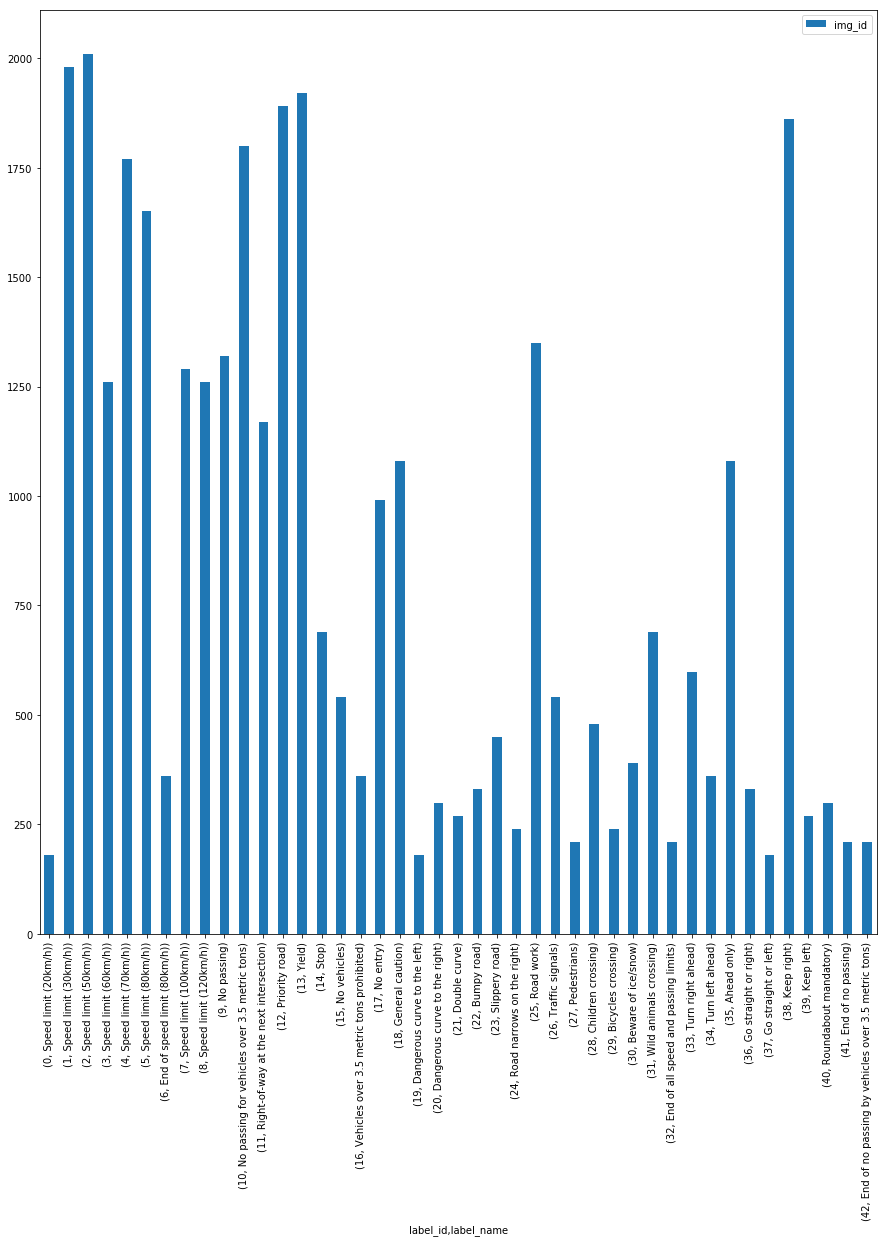

In [9]:
X_train_group_by_label_count.plot(kind='bar', figsize=(15,17))

This confirms the significant class imbalance we observed earlier. At this stage we will not attempt to address it.

#### Training Set Image Visualization <a name="8"></a>

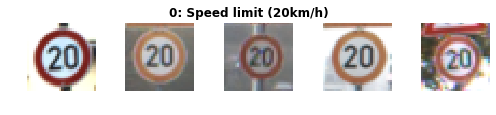

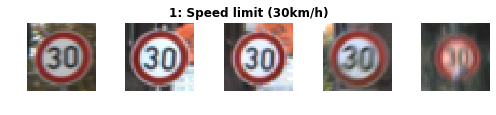

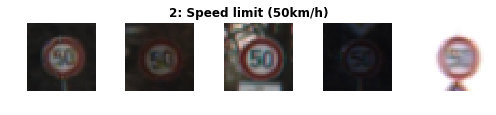

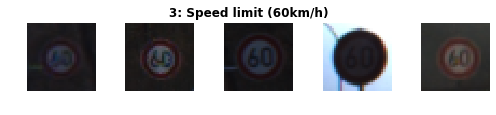

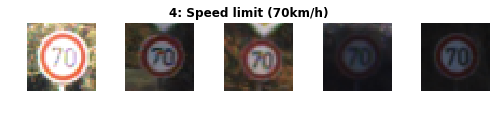

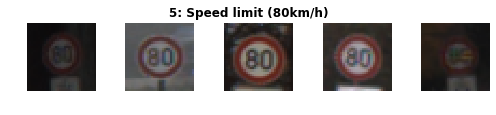

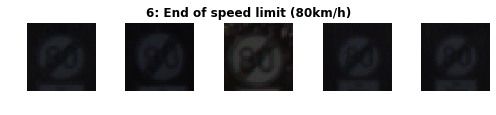

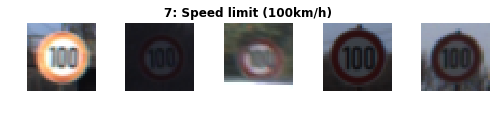

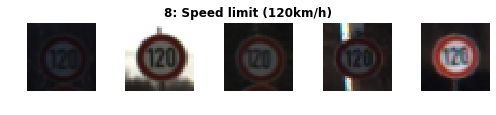

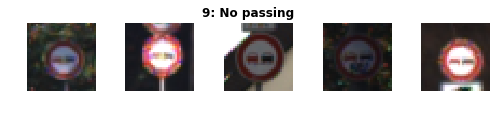

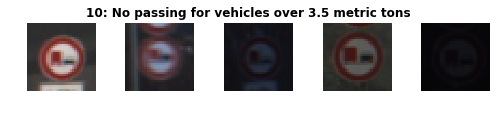

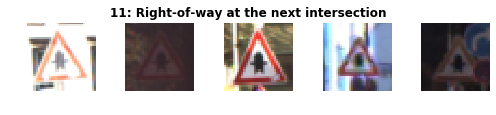

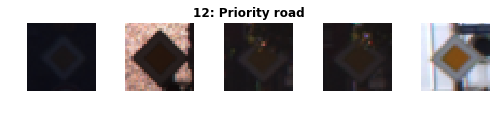

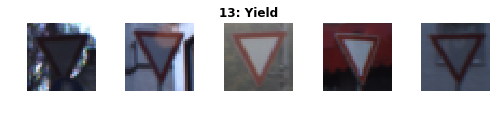

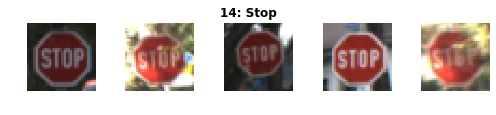

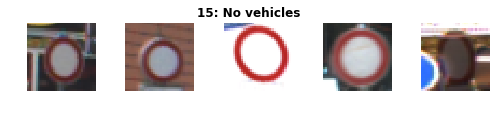

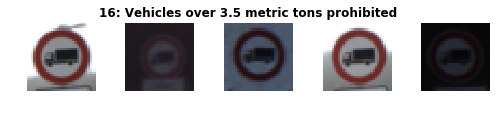

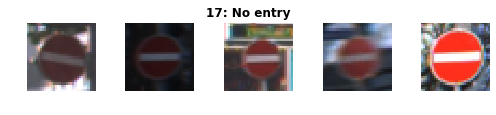

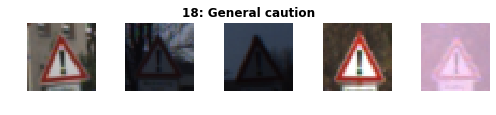

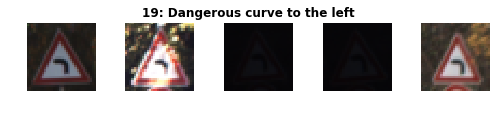

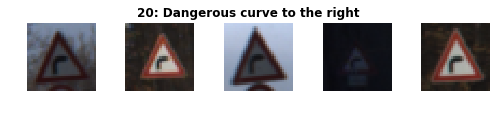

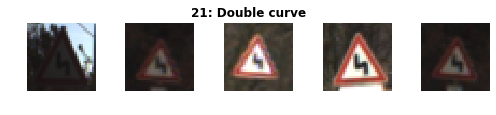

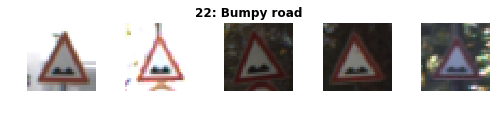

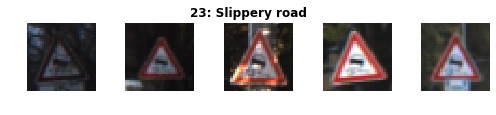

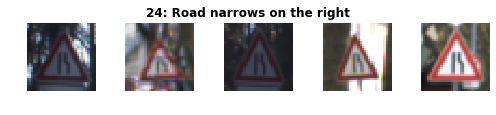

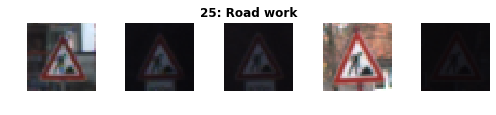

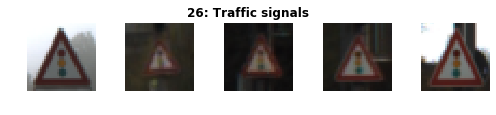

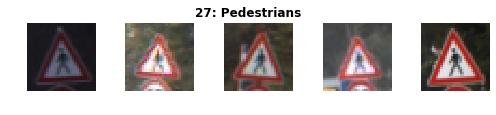

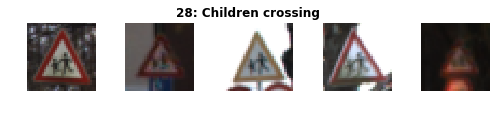

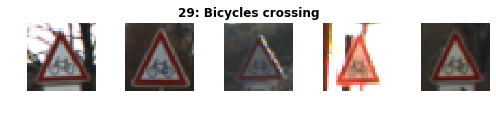

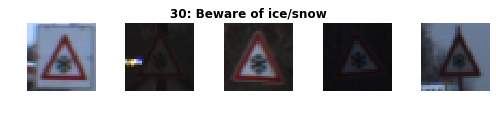

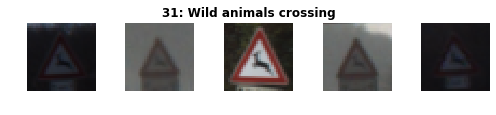

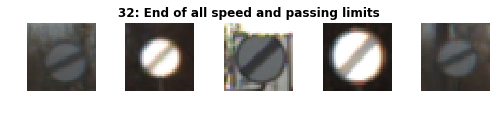

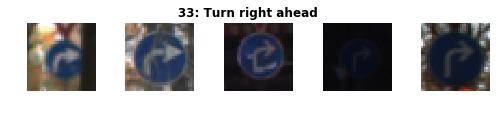

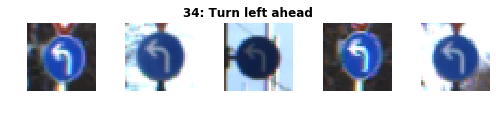

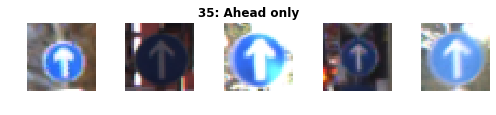

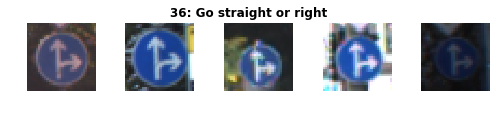

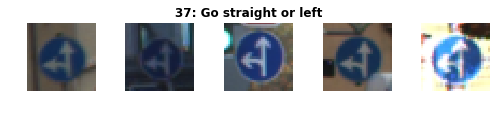

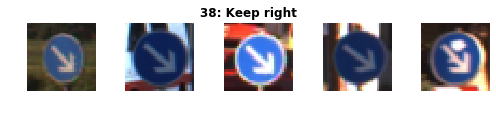

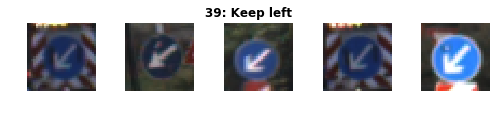

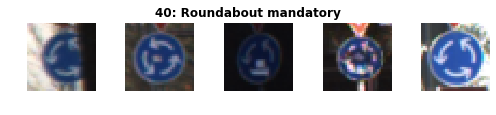

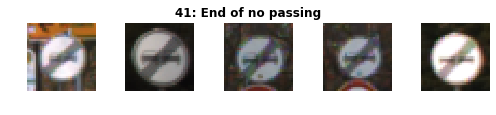

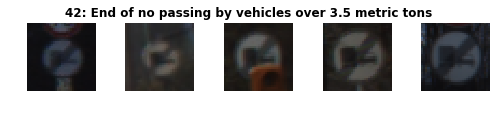

In [10]:
# Let's plot images from each of these classes
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5
show_random_datasets_images(X_train_group_by_label, X_train)

### Validation Set <a name="9"></a>
#### Group Images in Validatation Set <a name="10"></a>

In [12]:
# Create a data frame whereby we index id with label
X_valid_id_to_label = group_img_id_to_lbl(y_valid, sign_names)
# Print few of those mapping
X_valid_id_to_label.head(n=3)

img_id  label_id         label_name
0       0        41  End of no passing
1       1        41  End of no passing
2       2        41  End of no passing

In [13]:
# Group by label id to understand the distribution
X_valid_group_by_label_count = utils.group_img_id_to_lb_count(X_valid_id_to_label)
X_valid_group_by_label_count.head(n=5)

img_id
label_id label_name                  
0        Speed limit (20km/h)      30
1        Speed limit (30km/h)     240
2        Speed limit (50km/h)     240
3        Speed limit (60km/h)     150
4        Speed limit (70km/h)     210

#### Validation Set Distribution Visualization <a name="11"></a>

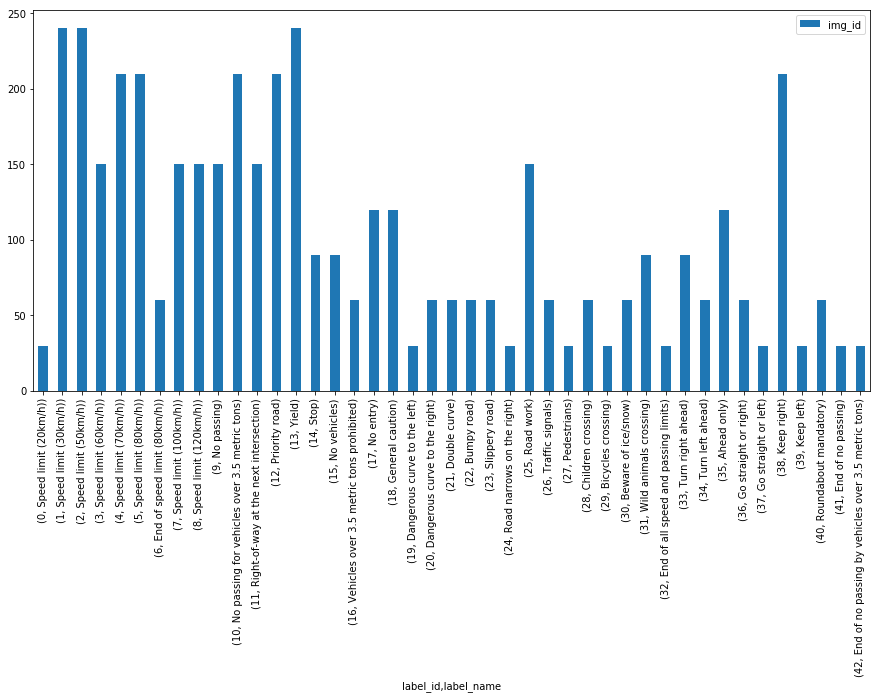

In [14]:
X_valid_group_by_label_count.plot(kind='bar', figsize=(15,7))

We also observe significant imbalance in the validation set. This is less of a problem as we do not train our data on it.

#### Validation Set Images Visualization <a name="12"></a>

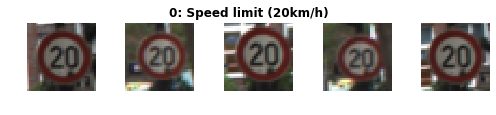

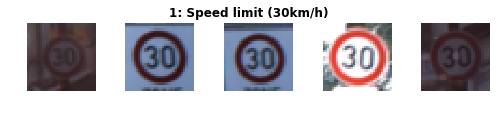

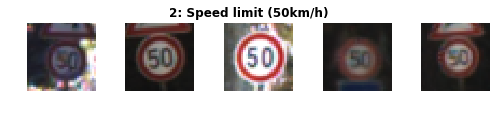

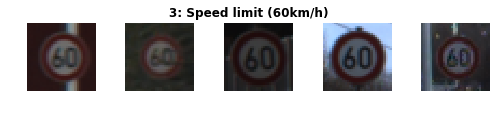

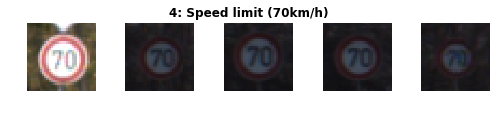

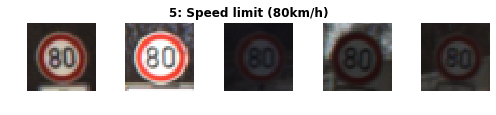

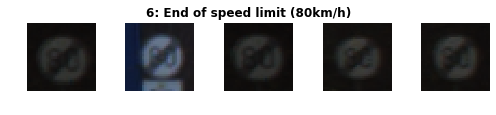

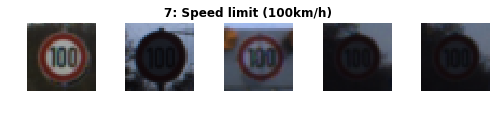

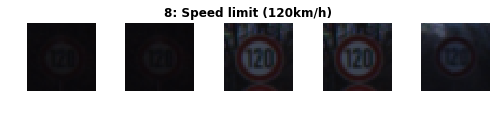

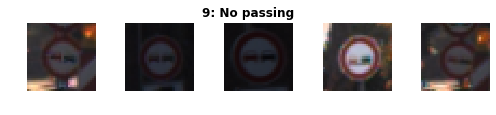

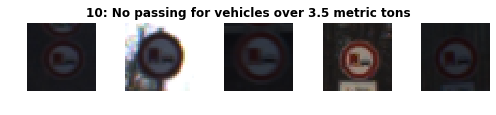

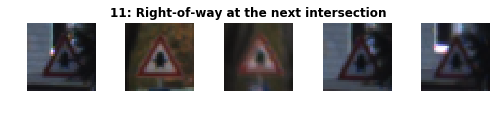

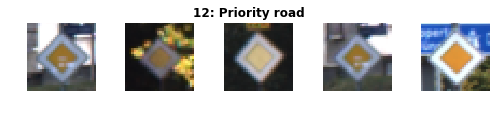

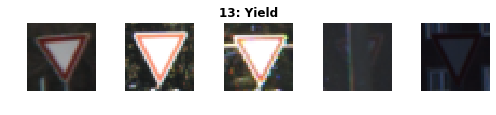

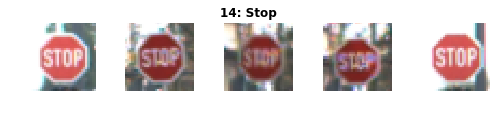

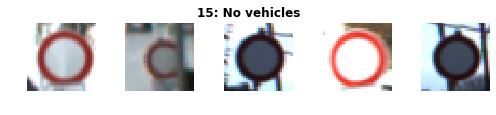

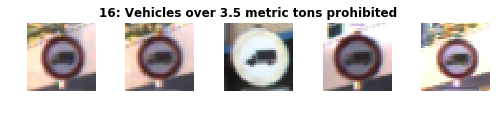

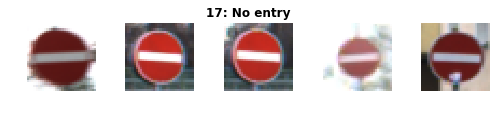

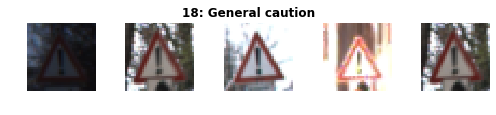

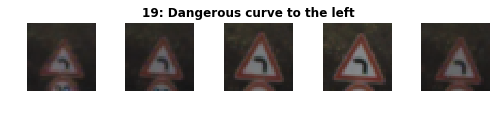

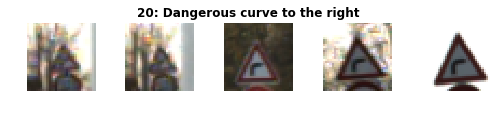

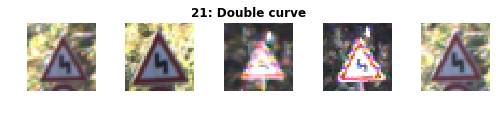

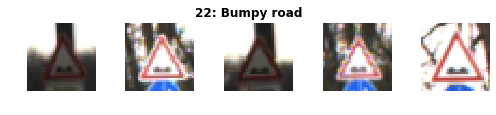

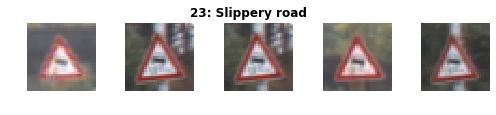

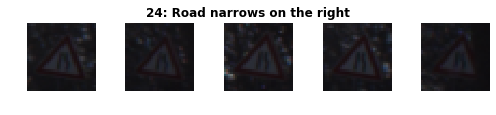

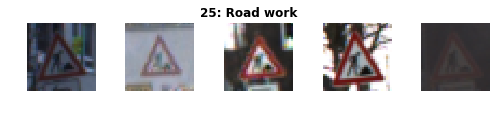

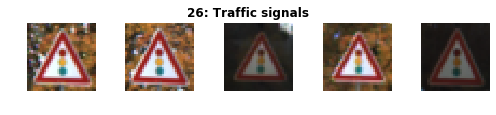

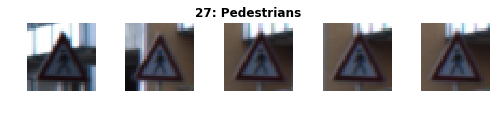

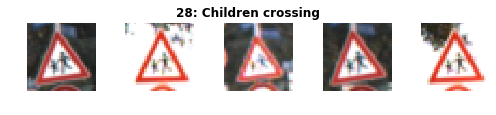

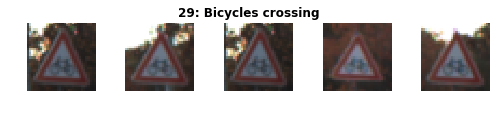

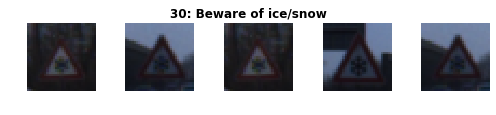

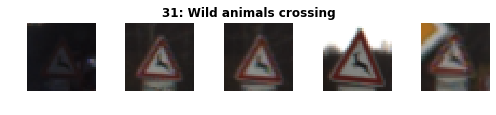

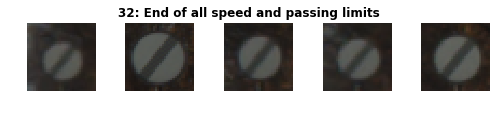

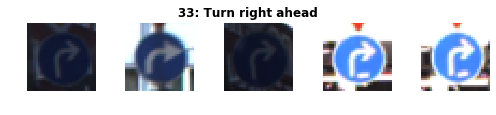

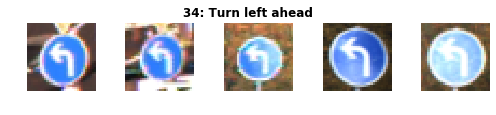

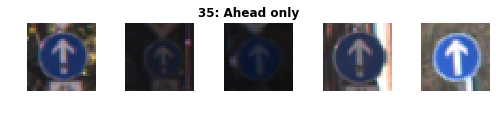

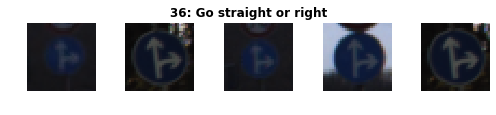

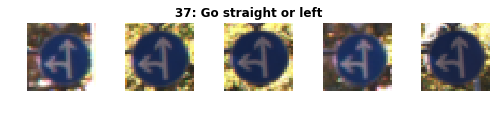

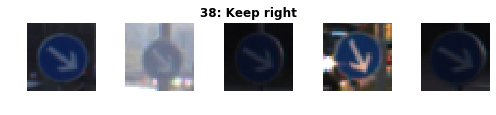

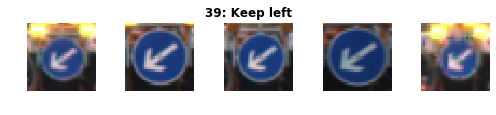

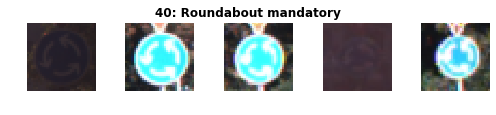

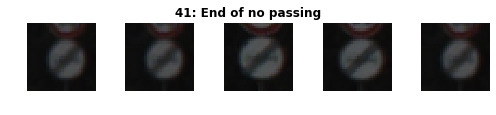

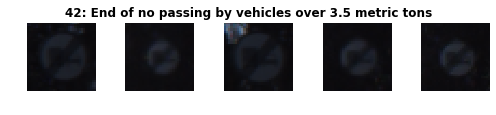

In [15]:
# Let's plot images from each of these classes
X_valid_group_by_label = X_valid_id_to_label.groupby(["label_id", "label_name"])
show_random_datasets_images(X_valid_group_by_label, X_valid)

## 3. Create a sample set <a name="13"></a>
As we have over 30 thousand images, we do not want to try every model on the whole dataset as this would be extremely time consuming. 
Instead, we create sample datasets for training and validation, where we copy a percentage P of both dataset.

In [16]:
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct = 0.33)
print("Sample training images dimension={0}, label dimensions={1}".format(X_sample_train.shape, y_sample_train.shape))

X_sample_valid, y_sample_valid = create_sample_set(X_valid_group_by_label, X_valid, y_valid, pct=0.33)
print("Sample validation images dimensions={0}, labels dimensions={1}".format(X_sample_valid.shape, y_sample_valid.shape))

Sample training images dimension=(11464, 32, 32, 3), label dimensions=(11464,)
Sample validation images dimensions=(1427, 32, 32, 3), labels dimensions=(1427,)


# II. Design and Test a Model Architecture <a name="14"></a>
Design and implement a deep learning model that learns to recognize traffic signs. Train and test model on the German Traffic Sign Dataset.

There are various aspects to consider when thinking about this problem:

    Neural network architecture (is the network over or underfitting?)
    Play around preprocessing techniques (normalization, rgb to grayscale, etc)
    Number of examples per label (some have more than others).
    Generate fake data.

## 1. Data Pre-Processing <a name="15"></a>

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, (pixel - 128)/ 128 is a quick way to approximately normalize the data and can be used in this project.

### Normalisation <a name="16"></a>

In [17]:
# Normalize training set
X_train_normalised = normalise_images(X_train, X_train)

In [18]:
# Do the same for training and validatiaon set 
X_valid_normalised = normalise_images(X_valid, X_train)
X_test_normalised = normalise_images(X_test, X_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


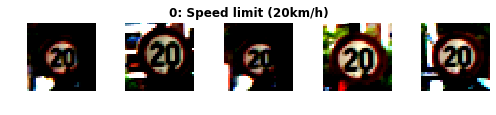

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


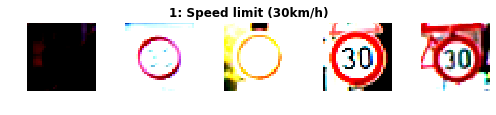

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


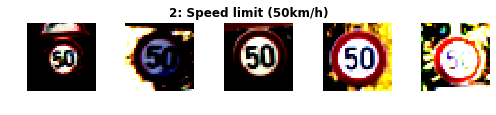

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


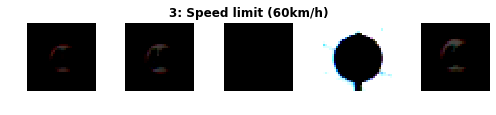

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


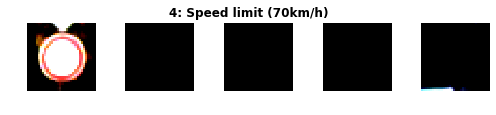

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


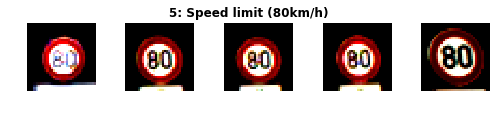

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


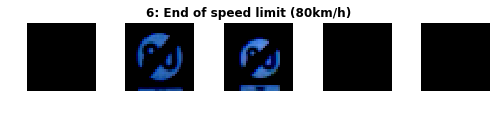

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


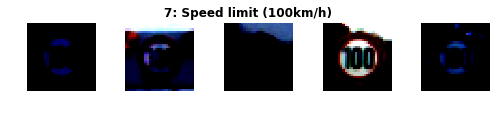

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


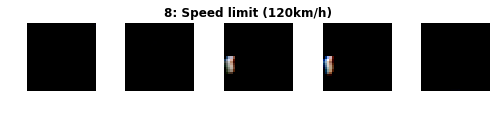

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


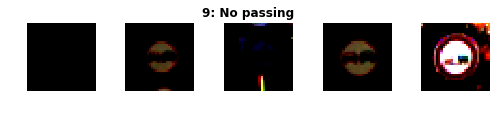

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


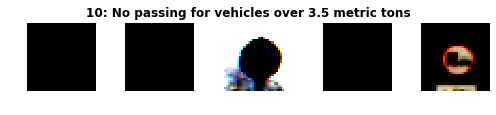

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


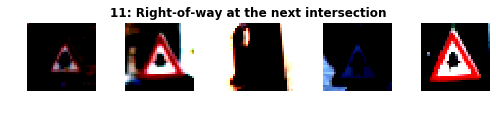

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


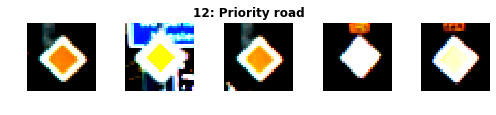

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


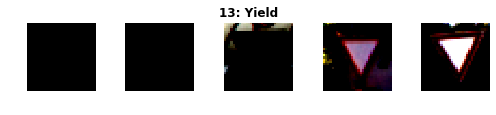

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


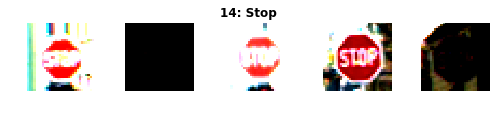

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


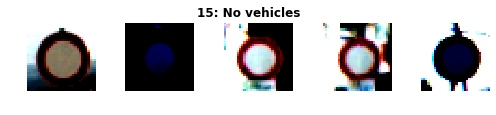

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


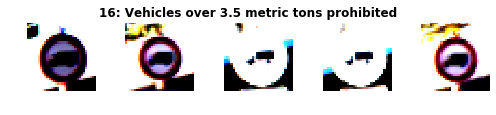

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


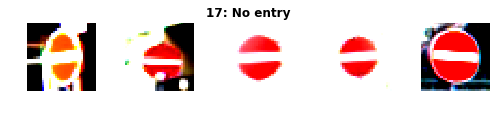

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


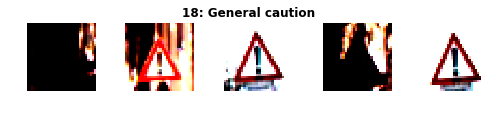

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


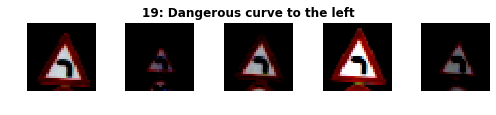

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


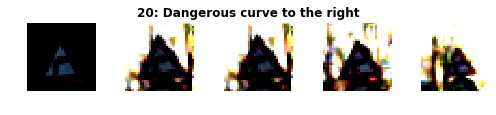

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


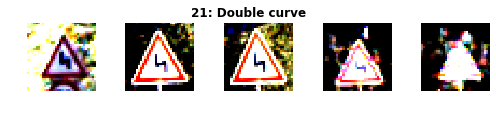

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


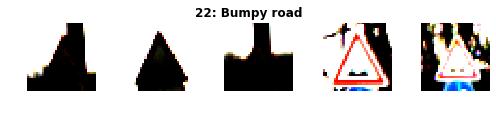

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


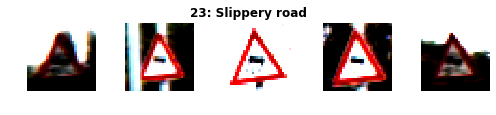

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


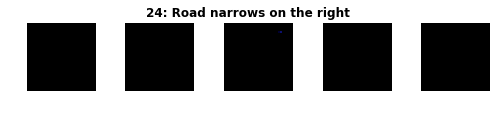

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


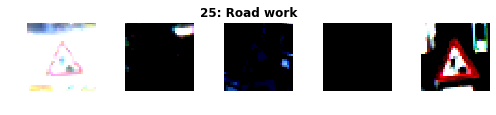

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


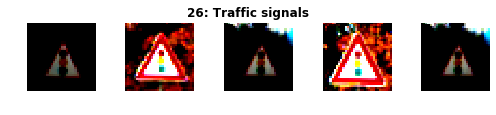

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


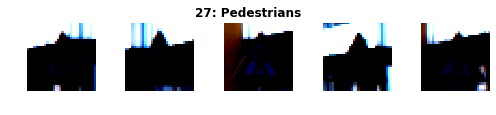

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


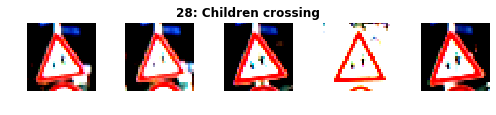

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


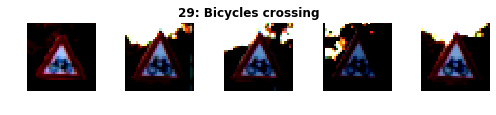

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


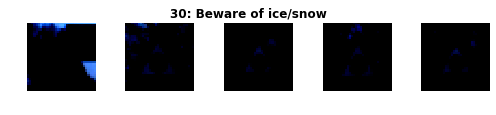

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


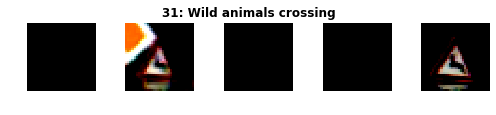

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


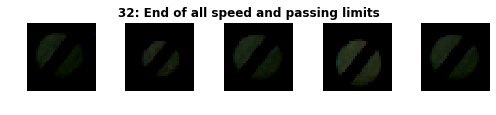

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


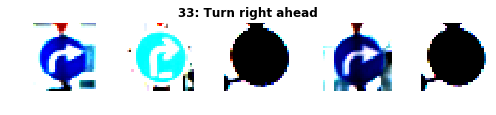

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


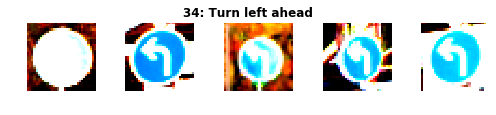

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


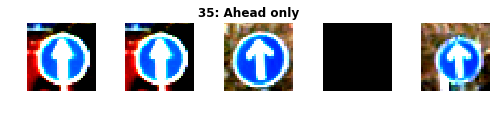

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


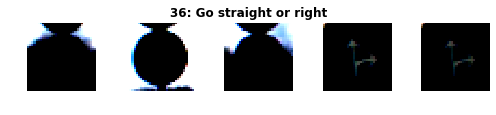

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


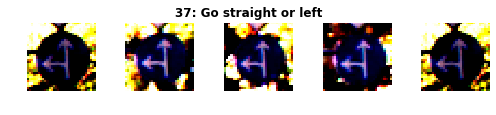

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


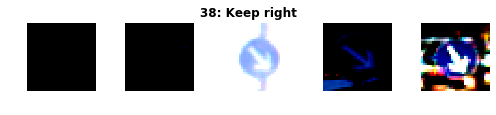

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


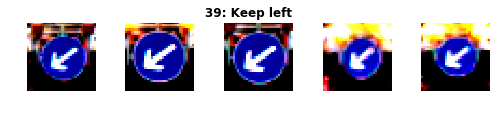

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


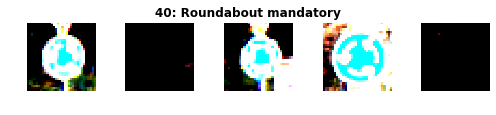

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


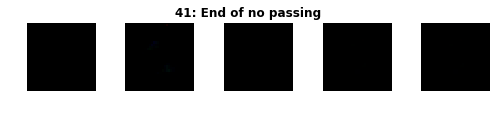

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


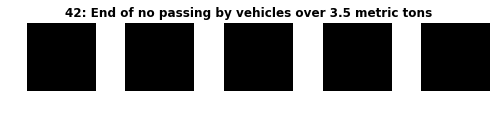

In [195]:
show_random_datasets_images(X_valid_group_by_label, X_valid_normalised)

### Grayscale <a name="17"></a>

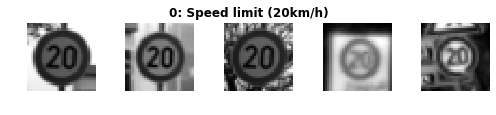

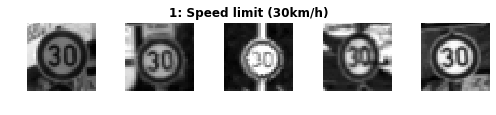

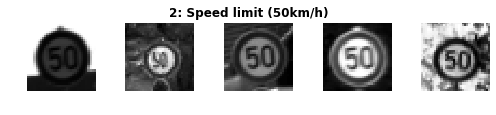

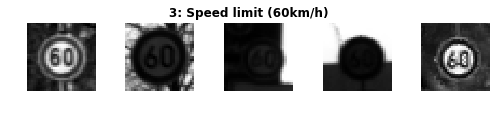

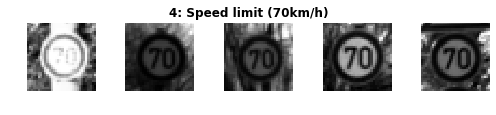

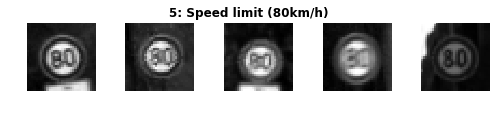

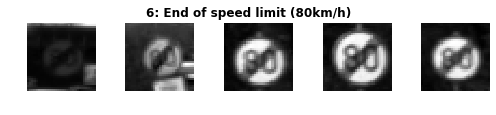

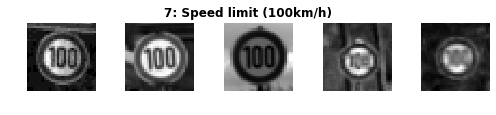

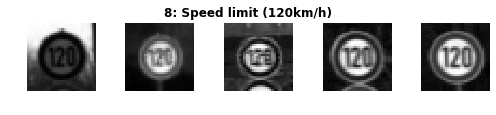

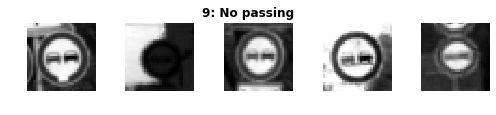

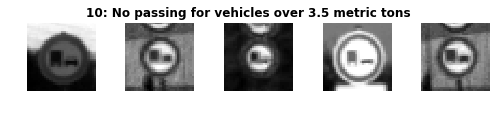

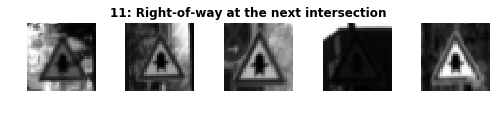

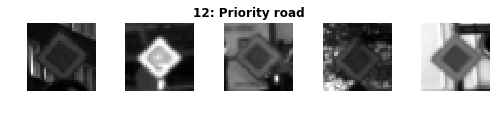

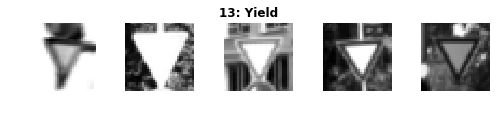

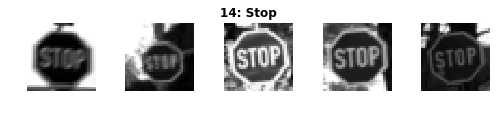

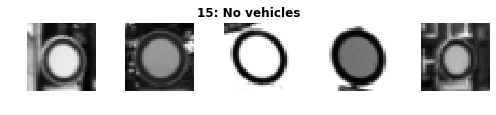

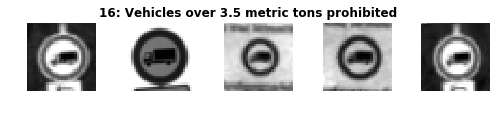

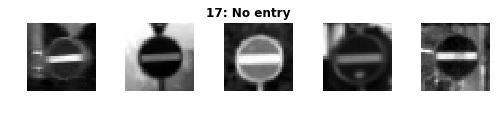

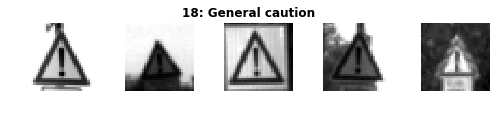

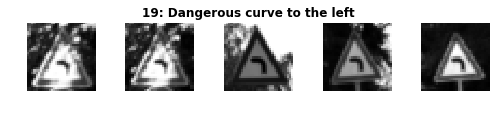

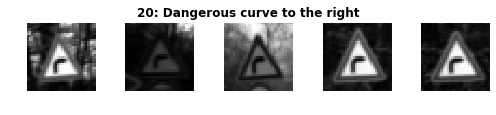

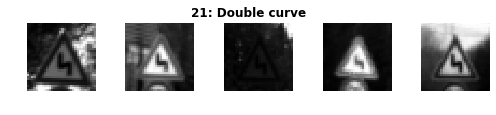

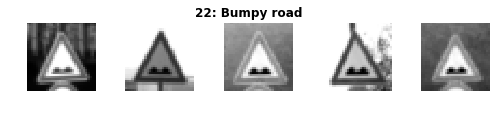

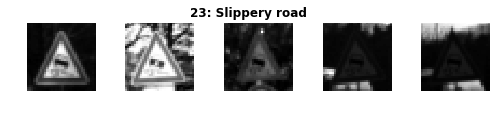

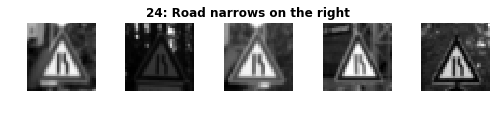

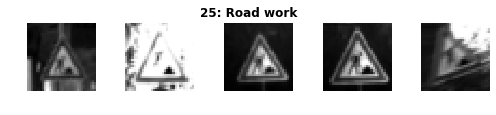

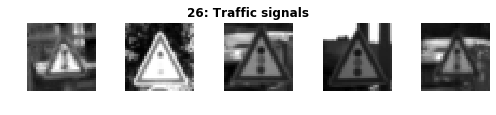

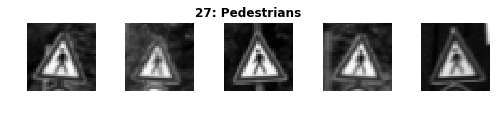

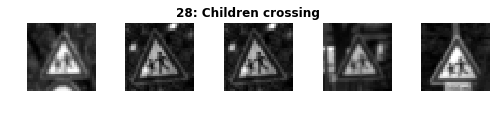

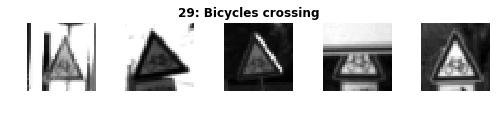

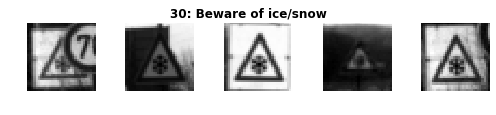

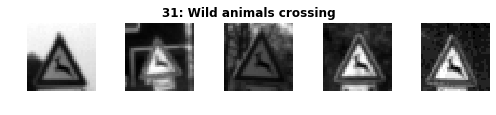

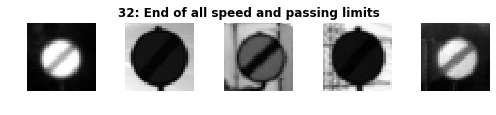

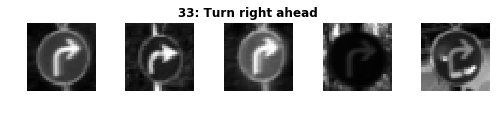

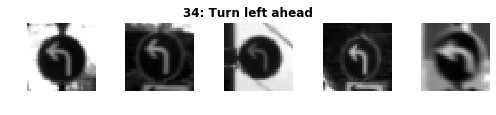

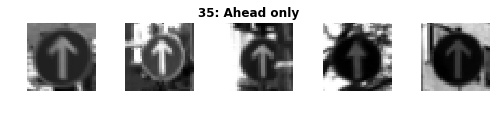

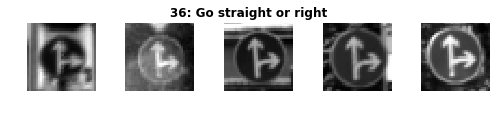

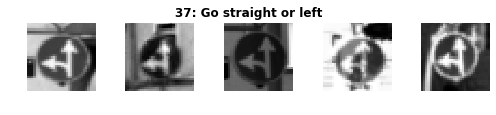

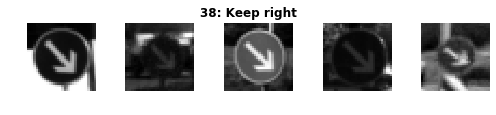

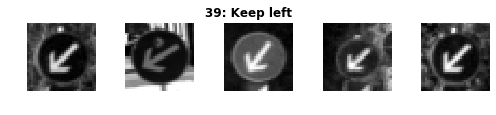

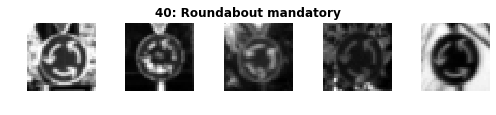

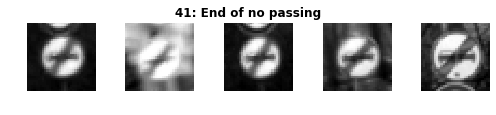

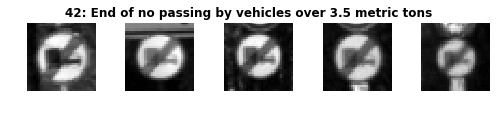

In [22]:
# Let's test our image graying features on training set
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train)))
show_random_datasets_images(X_train_group_by_label, X_train_grayscale)

We can see that grascalling somewhat improves teh visibility of the images, but some of them
still remain very dark. At this stage we will not address this problem

In [23]:
# Do the same on validation set
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid)))
# show_random_datasets_images(X_valid_group_by_label, X_valid_grayscale)

In [24]:
# Also grayscale test data
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test)))
# show_image_list(X_test_grayscale[10:13], y_test[10:13], "Gray image", cols=3, fig_size=(3, 3), show_ticks=False)


## 2. Model Architectures <a name="18"></a>

In this section, we will create a configurable neural network architectures where the number of layers as well as filter sizes can be modified. But first, we set up the pipeline to enable us to achieve our goal.

### Configuration and Execution pipeline <a name="19"></a>

We define the steps necessary to build a training pipeline in Tensorflow. These are defined as classes to increase flexibility.



In [25]:
class ModelConfig:
    """
    ModelConfig is a utility class that stores important configuration option about the model
    """
    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct):
        self.model = model
        self.name = name
        self.input_img_dimensions = input_img_dimensions
        
        # Determine the wxh dimensions of filters, the starting depth (increases by x2 at y layer)
        # and how many convolutional layers the network has
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        self.conv_layers_count = conv_layers_config[2]
        
        self.fc_output_dims = fc_output_dims
        self.output_classes = output_classes
        
        # Try with different values for dropout at convolutional and fully connected layers
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]
    

In [137]:
class ModelExecutor:
    """
    Model Executor is responsible for executing the supplied model
    """
    def __init__(self, model_config, learning_rate = 0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
        
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope(self.model_config.name) as scope:
                # Create Model operations
                self.create_model_operations()
                
                # Create a saver to persist the results of execution
                self.saver = tf.train.Saver()
                
    def create_placeholders(self):
        """
        Defining our placeholder variables
        - x, y
        - one_hot y
        - dropout placeholders
        """
        # eg 32*32*3
        input_dims = self.model_config.input_img_dimensions
        self.x = tf.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), 
                                name="{0}_x".format(self.model_config.name))
        
        self.y = tf.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)
        
        self.dropout_placeholder_conv = tf.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.placeholder(tf.float32)
        
    def create_model_operations(self):
        """
        Set up all operations needed to execute run deep learning pipeline
        """
        
        # First step is to set our x, y, etc
        self.create_placeholders()
        # Get the model configuration
        cnn = self.model_config.model
        
        # Build the network - TODO: pass the configuration in the future
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        # Obviously, using softmax as the activation functions for the final layer
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = self.one_hot_y, logits = self.logits)
        
        # Combined all the losses across the batches
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        
        # What method do we use to reduce our loss
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # Create training operation: reduce the loss using chosen optimizer
        self.training_operation = self.optimizer.minimize(self.loss_operation)
        
        # Get the top prediction for model against labels and check whether the match
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        # compute accuracy at batch level
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        # compute what the prediction would be, when we dont have matching label
        self.prediction = tf.argmax(self.logits, 1)
        
        # Registering our top 5 predictions
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k = 5, sorted=True, name=None)
        
    
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        Evaluate teh models's accuracy and loss for the supplied dataset
        Naturally, Dropout is ignored in this case (i.e. we set dropout_keep_pct to 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 1.0
        total_loss = 0.0
        sess = tf.get_default_session()
        
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # Compute both accuracy and loss for this batch
            accuracy = sess.run(self.accuracy_operation, 
                               feed_dict={
                                   self.dropout_placeholder_conv: 1.0,
                                   self.dropout_placeholder_fc: 1.0,
                                   self.x: batch_x,
                                   self.y: batch_y
                               })
            loss = sess.run(self.loss_operation, feed_dict={
                self.dropout_placeholder_conv: 1.0,
                self.dropout_placeholder_fc: 1.0,
                self.x: batch_x,
                self.y: batch_y
            })
            
            # Weighting accuracy by the total number of elements in batch
            total_accuracy += (accuracy * len(batch_x))
            total_loss += (loss*len(batch_x))
            
        # To produce true mean accuracy over whole dataset
        return (total_accuracy / num_examples, total_loss / num_examples)
    

    def train_model(self, X_train_features, X_train_labels, X_valid_features, y_valid_labels, batch_size=512, 
                    epochs=100, PRINT_FREQ=10):
        """
        Trains the model for the specified number of epochs supplied when creating the executor
        """
        
        # Create array of metrics
        training_metrics = np.zeros((epochs, 3))
        validation_metrics = np.zeros((epochs, 3))
        
        with tf.Session(graph=self.graph, config = tf.ConfigProto(allow_soft_placement=True,
                                                                 log_device_placement=True)) as sess:
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_features)
            
            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, 
                                                                          epochs, batch_size))
            
            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y,
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct
                    })
                    
                end_training_time = time.time()
                training_duration = end_training_time - start
                
                # Computing training accuracy
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)
                
                # Computing validation accuracy
                validation_accuracy, validation_loss = self.evaluate_model(X_valid_features, y_valid_labels, batch_size)
                
                end_epoch_time = time.time()
                validation_duration = end_epoch_time - end_training_time
                epoch_duration = end_epoch_time - start
                
                
                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, loss={3:.4f}, acc={4:.4f} | val: time={5:.3f}s, loss={6:.4f}, acc={7:.4f}".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy, 
                        validation_duration, validation_loss, validation_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]
                validation_metrics[i] = [validation_duration, validation_loss, validation_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # Save the model
            self.saver.save(sess, model_file_name)
            print("Model {0} saved".format(model_file_name))
                  
        return(training_metrics, validation_metrics, epoch_duration)
                  
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        Evaluates the model with the test dataset and test labels
        Return the tuple (test accuracy, test_loss, duration)
        """
        with tf.Session(graph = self.graph) as sess:
            # Re-initializer variables
            tf.global_variables_initializer()
            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            
            start_time = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start_time
            
            print("[{0} - Test set]\t time={1:.3f}s, loss={2:.4f}, acc={3:.4f}".format(self.model_config.name,
                                                                                   duration, test_loss, test_accuracy))
            
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        Return the predictions associated with a bunch of images
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # re-initialize the variables
            tf.global_variables_initializer()
            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                    self.x:imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
        return preds
    
    
    def show_conv_feature_map(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1,
                             plt_num=1, fig_size=(15,15), title_y_pos=1.0):
        """
        Show the resulting feature maps at a given convolutional level for a single image
        """
        with tf.Session(graph = self.graph) as sess:
            # re-initialise the variables
            tf.global_variables_initializer()
            #tf.reset_default_graph()
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
        # Run a prediction
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
        
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
        
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
        
            print("Shape of activation layer: {0}".format(activation.shape))
            
        #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k
                
                    if activation_min != -1 & activation_max != -1:
                            ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

                    ax.axis("off")
                    k += 1

            fig.suptitle("Feature Maps at layer: {0}".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()

### EdLe Net <a name="20"></a>

We implement simple variant LeNet by Yann Le Cun, comically named EdLeNet. We make the network highly configurable so that we can assess its different variants and determine which one provides the most accuracy.

In [27]:
from tensorflow.contrib.layers import flatten

def EdLeNet(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    A variant of LeNet created by Yann Le Cun
    The second parameter, which is encapsulates model configuration, enables varying the convolution filter sizes 
    as well as the number of fully connected layers and their output dimensions.
    The third and fourth parameters represent dropout placeholders for convolutional and fully connected layers respectively
    """
    
    # Used for randomly definining weights and biases
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[EdLeNet] Building neural network [conv layers={0}, conv filter size={1}, conv start depth={2}, fc layers={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    # Loop through all conv layers
    for i in range(0, mc.conv_layers_count):
        # layer depth grows exponetially
        conv_output_depth = conv_depth * (2**(i))
        conv_W = tf.Variable(tf.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth,
                                                       conv_output_depth), mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1,1,1,1], padding='VALID', 
                                    name="conv_{0}".format(i)) + conv_b
        conv_output  = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # tradditional max 2x2 pool
        conv_output = tf.nn.max_pool(conv_output, ksize = [1,2,2,1], strides=[1,2,2,1], padding='VALID')
        # Apply dropout - even at the conv layer
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct)
        
        # Setting our loop variables accordingly
        prev_conv_layer = conv_output 
        conv_input_depth = conv_output_depth
        
    # Flatten result of second convolutional layer so that it can be supplied to fully connected layer
    fc0 = flatten(prev_conv_layer)
    
    # Now creating our fully connected layers
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim),
                                               mean = mu, stddev = sigma))
        fcn_b = tf.Variable(tf.zeros(output_dim))
        prev_layer = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)
        
    # Final layer (fully connected)
    fc_final_W = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes),
                            mean = mu, stddev = sigma))
    fc_final_b = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits

                                                                                                                                                                        

## 3. Train, Validate and Test the Model <a name="21"></a>

### Non Normalised images <a name="22"></a>
Let's begin with color and grayscale non-normalised images, changing feature size

#### Color Sample Dataset <a name="23"></a>

In [59]:
# ModelConfig(model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct)
# mc stands for model config
# input_img_dimensions = [32,32,3]
# conv_layers_config = [3,16,3] means conv layers =3, conv filter size = 3, conv start depth = 16
# fc_output_dims = [120, 84] means there are 2 fc layers, first one has 120 and second has 80 nodes.
# output_classes = n_classes = 43
# dropout_keep_pct = [1,1] for both conv and fc
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Sample", [32,32,3], [3,16,3],[120,84], n_classes, [1.0,1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_5x5_Color_Sample", [32, 32, 3], [5, 16, 2], [120, 84], n_classes, [1.0, 1.0])
mc_7x7 = ModelConfig(EdLeNet, "EdLeNet_7x7_Color_Sample", [32, 32, 3], [7, 16, 2], [120, 84], n_classes, [1.0, 1.0])


In [60]:
# me stands for model executor
me_c_sample_3x3 = ModelExecutor(mc_3x3)
me_c_sample_5x5 = ModelExecutor(mc_5x5)
me_c_sample_7x7 = ModelExecutor(mc_7x7)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=16, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=16, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=7, conv start depth=16, fc layers=2]


In [61]:
(c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics, c_sample_3x3_duration) = me_c_sample_3x3.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_3x3_ts_metrics, c_sample_3x3_ts_loss, c_sample_3x3_ts_duration) = me_c_sample_3x3.test_model(X_test, y_test)

Training EdLeNet_3x3_Color_Sample [epochs=50, batch_size=512]...

[1]	total=7.025s | train: time=3.783s, loss=3.4730, acc=0.1289 | val: time=3.242s, loss=3.6327, acc=0.1282
[10]	total=6.772s | train: time=3.622s, loss=0.4476, acc=0.8778 | val: time=3.150s, loss=1.2606, acc=0.7183
[20]	total=7.334s | train: time=3.925s, loss=0.0899, acc=0.9798 | val: time=3.408s, loss=1.3266, acc=0.8059
[30]	total=7.329s | train: time=3.921s, loss=0.0235, acc=0.9969 | val: time=3.409s, loss=1.4727, acc=0.8164
[40]	total=7.470s | train: time=3.906s, loss=0.0096, acc=0.9995 | val: time=3.564s, loss=1.5912, acc=0.8346
[50]	total=7.604s | train: time=4.030s, loss=0.0035, acc=1.0000 | val: time=3.574s, loss=1.7735, acc=0.8381
Model ./models/EdLeNet_3x3_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_3x3_Color_Sample.chkpt
[EdLeNet_3x3_Color_Sample - Test set]	 time=3.641s, loss=2.0882, acc=0.8185


In [62]:
(c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_5x5_duration) = me_c_sample_5x5.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_5x5_ts_metrics, c_sample_5x5_ts_loss, c_sample_5x5_ts_duration) = me_c_sample_5x5.test_model(X_test, y_test)

Training EdLeNet_5x5_Color_Sample [epochs=50, batch_size=512]...

[1]	total=10.152s | train: time=5.668s, loss=4.2887, acc=0.1234 | val: time=4.484s, loss=4.4143, acc=0.1114
[10]	total=10.501s | train: time=5.764s, loss=0.4183, acc=0.8902 | val: time=4.737s, loss=1.6175, acc=0.7015
[20]	total=11.089s | train: time=5.972s, loss=0.0602, acc=0.9908 | val: time=5.117s, loss=1.8226, acc=0.7898
[30]	total=11.660s | train: time=6.118s, loss=0.0137, acc=0.9993 | val: time=5.542s, loss=2.2111, acc=0.8031
[40]	total=11.273s | train: time=6.223s, loss=0.0049, acc=1.0001 | val: time=5.050s, loss=2.5036, acc=0.8052
[50]	total=11.195s | train: time=5.973s, loss=0.0023, acc=1.0001 | val: time=5.222s, loss=2.6767, acc=0.8080
Model ./models/EdLeNet_5x5_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_5x5_Color_Sample.chkpt
[EdLeNet_5x5_Color_Sample - Test set]	 time=5.165s, loss=1.8685, acc=0.8182


In [63]:
(c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_7x7_duration) = me_c_sample_7x7.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_7x7_ts_metrics, c_sample_7x7_ts_loss, c_sample_7x7_ts_duration) = me_c_sample_7x7.test_model(X_test, y_test)

Training EdLeNet_7x7_Color_Sample [epochs=50, batch_size=512]...

[1]	total=14.122s | train: time=6.848s, loss=6.4398, acc=0.0807 | val: time=7.274s, loss=6.8888, acc=0.0617
[10]	total=13.637s | train: time=6.438s, loss=0.7016, acc=0.8050 | val: time=7.200s, loss=1.6822, acc=0.6566
[20]	total=13.896s | train: time=6.462s, loss=0.1492, acc=0.9638 | val: time=7.434s, loss=1.7585, acc=0.7575
[30]	total=13.631s | train: time=6.693s, loss=0.0458, acc=0.9921 | val: time=6.938s, loss=2.0794, acc=0.7835
[40]	total=13.980s | train: time=7.072s, loss=0.0195, acc=0.9974 | val: time=6.908s, loss=2.2288, acc=0.7975
[50]	total=12.855s | train: time=6.319s, loss=0.0058, acc=1.0001 | val: time=6.536s, loss=2.4143, acc=0.8080
Model ./models/EdLeNet_7x7_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_7x7_Color_Sample.chkpt
[EdLeNet_7x7_Color_Sample - Test set]	 time=6.967s, loss=2.5589, acc=0.7946


The 7x7 model has much lower loss than the other two on the validation and test sets. We will run the 3x3 and 5x5 models side by side from now on to compare the results, as the 7x7 model seems to produce the worst result.

Length of axis: (2,)


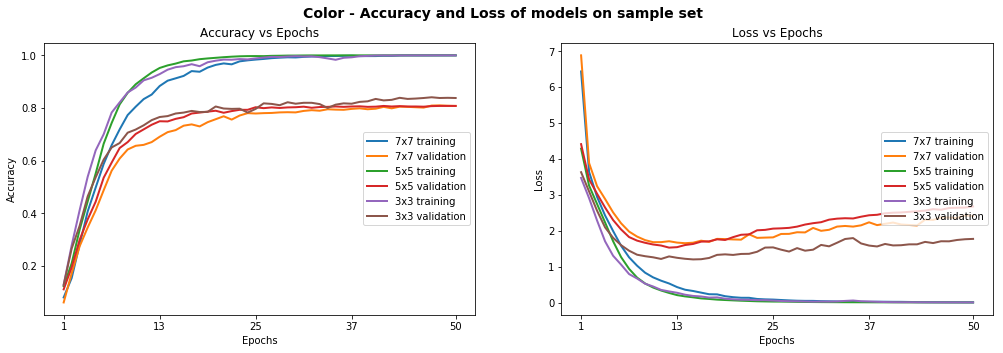

In [71]:
metrics_arr = [c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, 
              c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics]
lbs = ["7x7 training", "7x7 validation", "5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]

plot_model_results(metrics_arr, [2,1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"],
                  ["Accuracy vs Epochs", "Loss vs Epochs"], "Color - Accuracy and Loss of models on sample set",
                  fig_size=(17,5))

#### Color Full Dataset <a name="24"></a>

We now run the 3x3 and 5x5 models on the full color dataset. We also took the liberty to increase the depth of our convolutional layers as we have observed better information starting at 32, rather than 16.

In [73]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Full_Color_3x3", [32,32,3], [3,32,3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Full_Color_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

me_c_3x3 = ModelExecutor(mc_3x3)
me_c_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [74]:
(c_3x3_tr_metrics, c_3x3_val_metrics, c_3x3_duration) = me_c_3x3.train_model(X_train, y_train, X_valid, y_valid, epochs=100)
(c_3x3_ts_accuracy, c_3x3_ts_loss, c_3x3_ts_duration) =  me_c_3x3.test_model(X_test, y_test)

Training EdLeNet_Full_Color_3x3 [epochs=100, batch_size=512]...

[1]	total=125.328s | train: time=71.513s, loss=2.5731, acc=0.3386 | val: time=53.815s, loss=2.8384, acc=0.3050
[10]	total=120.094s | train: time=65.660s, loss=0.0786, acc=0.9786 | val: time=54.434s, loss=1.0142, acc=0.8351
[20]	total=120.587s | train: time=66.876s, loss=0.0372, acc=0.9897 | val: time=53.711s, loss=1.0663, acc=0.8744
[30]	total=120.006s | train: time=67.708s, loss=0.0012, acc=1.0000 | val: time=52.298s, loss=1.0318, acc=0.8957
[40]	total=120.744s | train: time=67.985s, loss=0.0004, acc=1.0000 | val: time=52.759s, loss=1.1306, acc=0.8986
[50]	total=121.145s | train: time=66.678s, loss=0.0002, acc=1.0000 | val: time=54.467s, loss=1.2100, acc=0.8966
[60]	total=121.995s | train: time=67.453s, loss=0.0001, acc=1.0000 | val: time=54.542s, loss=1.2761, acc=0.8948
[70]	total=120.145s | train: time=66.327s, loss=0.0001, acc=1.0000 | val: time=53.818s, loss=1.3308, acc=0.8955
[80]	total=121.420s | train: time=68.193

In [75]:
(c_5x5_tr_metrics, c_5x5_val_metrics, c_5x5_duration) = me_c_5x5.train_model(X_train, y_train, X_valid, y_valid, epochs=100)
(c_5x5_ts_accuracy, c_5x5_ts_loss, c_5x5_ts_duration) =  me_c_5x5.test_model(X_test, y_test)

Training EdLeNet_Full_Color_5x5 [epochs=100, batch_size=512]...

[1]	total=151.015s | train: time=79.555s, loss=3.1719, acc=0.2198 | val: time=71.460s, loss=3.4379, acc=0.2011
[10]	total=154.649s | train: time=82.530s, loss=0.0992, acc=0.9741 | val: time=72.119s, loss=1.1677, acc=0.8283
[20]	total=151.476s | train: time=80.614s, loss=0.0136, acc=0.9976 | val: time=70.862s, loss=1.2784, acc=0.8621
[30]	total=153.043s | train: time=80.871s, loss=0.0044, acc=0.9995 | val: time=72.173s, loss=1.1546, acc=0.8805
[40]	total=150.502s | train: time=79.799s, loss=0.0008, acc=1.0000 | val: time=70.702s, loss=1.2018, acc=0.9009
[50]	total=148.796s | train: time=78.422s, loss=0.0002, acc=1.0000 | val: time=70.375s, loss=1.3761, acc=0.9016
[60]	total=150.577s | train: time=78.304s, loss=0.0001, acc=1.0000 | val: time=72.273s, loss=1.4635, acc=0.9016
[70]	total=150.904s | train: time=80.622s, loss=0.0001, acc=1.0000 | val: time=70.282s, loss=1.5420, acc=0.9009
[80]	total=152.548s | train: time=80.841

Length of axis: (2,)


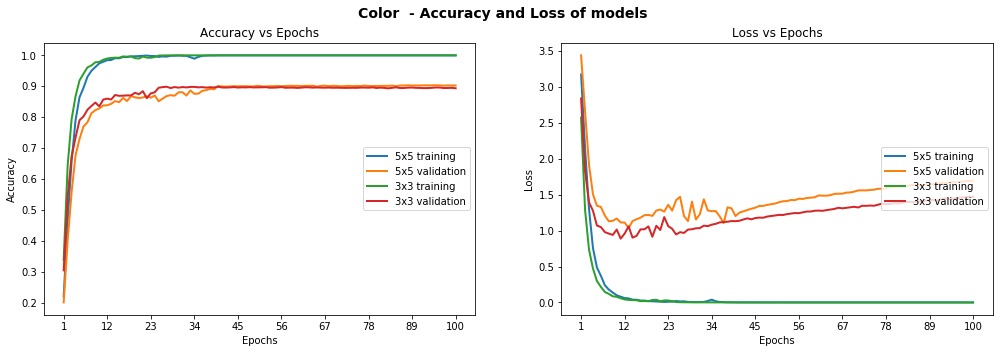

In [76]:
metrics_arr = [c_5x5_tr_metrics, c_5x5_val_metrics, c_3x3_tr_metrics, c_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

Interesting, the 5x5 model is the one that shows the most overfit, and produces significantly higher losses than the 3x3 model. This could be due to the fact that we have a deeper network that uses less coarse convolutions and therefore is able to extract more features. We are next going to test the model on grayscale images.

#### Grayscale Full Dataset <a name="25"></a>

In [28]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_grayscale = np.reshape(X_train_grayscale, (X_train_grayscale.shape[0], 32, 32, 1))
X_valid_grayscale = np.reshape(X_valid_grayscale, (X_valid_grayscale.shape[0], 32, 32, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (X_test_grayscale.shape[0], 32, 32, 1))

In [29]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [30]:
me_g_3x3 = ModelExecutor(mc_3x3)
me_g_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [31]:
(g_3x3_tr_metrics, g_3x3_val_metrics, g_3x3_duration) = me_g_3x3.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_valid, epochs=100)
(g_3x3_ts_accuracy, g_3x3_loss, g_3x3_ts_duration) = me_g_3x3.test_model(X_test_grayscale, y_test)

Training EdLeNet_Grayscale_3x3 [epochs=100, batch_size=512]...

[1]	total=35.699s | train: time=19.444s, loss=2.7239, acc=0.3533 | val: time=16.254s, loss=3.0735, acc=0.3023
[10]	total=45.424s | train: time=25.188s, loss=0.0911, acc=0.9754 | val: time=20.236s, loss=0.7740, acc=0.8612
[20]	total=47.510s | train: time=25.348s, loss=0.0511, acc=0.9882 | val: time=22.162s, loss=0.8836, acc=0.8839
[30]	total=47.609s | train: time=25.840s, loss=0.0199, acc=0.9944 | val: time=21.769s, loss=0.6924, acc=0.9127
[40]	total=47.562s | train: time=25.841s, loss=0.0006, acc=1.0000 | val: time=21.721s, loss=0.8435, acc=0.9179
[50]	total=46.042s | train: time=25.656s, loss=0.0003, acc=1.0000 | val: time=20.386s, loss=0.9575, acc=0.9177
[60]	total=44.411s | train: time=25.631s, loss=0.0001, acc=1.0000 | val: time=18.781s, loss=1.0235, acc=0.9186
[70]	total=39.498s | train: time=21.631s, loss=0.0001, acc=1.0000 | val: time=17.867s, loss=1.1064, acc=0.9190
[80]	total=38.394s | train: time=20.576s, loss=0.

In [32]:
(g_5x5_tr_metrics, g_5x5_val_metrics, g_5x5_duration) = me_g_5x5.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_valid, epochs=100)
(g_5x5_ts_accuracy, g_5x5_ts_loss, g_5x5_ts_duration) =  me_g_5x5.test_model(X_test_grayscale, y_test)

Training EdLeNet_Grayscale_5x5 [epochs=100, batch_size=512]...

[1]	total=47.667s | train: time=26.265s, loss=3.2515, acc=0.1850 | val: time=21.401s, loss=3.3871, acc=0.1798
[10]	total=46.671s | train: time=25.261s, loss=0.1236, acc=0.9686 | val: time=21.411s, loss=0.9232, acc=0.8442
[20]	total=47.415s | train: time=25.675s, loss=0.0340, acc=0.9910 | val: time=21.740s, loss=1.0492, acc=0.8692
[30]	total=48.979s | train: time=27.977s, loss=0.0071, acc=0.9990 | val: time=21.002s, loss=1.0798, acc=0.8921
[40]	total=46.874s | train: time=25.078s, loss=0.1659, acc=0.9605 | val: time=21.796s, loss=1.3167, acc=0.8497
[50]	total=46.737s | train: time=25.769s, loss=0.0011, acc=1.0000 | val: time=20.967s, loss=1.2541, acc=0.9079
[60]	total=45.685s | train: time=24.754s, loss=0.0005, acc=1.0000 | val: time=20.931s, loss=1.3187, acc=0.9086
[70]	total=52.418s | train: time=28.052s, loss=0.0002, acc=1.0000 | val: time=24.367s, loss=1.3990, acc=0.9079
[80]	total=50.594s | train: time=28.959s, loss=0.

Length of axis: (2,)


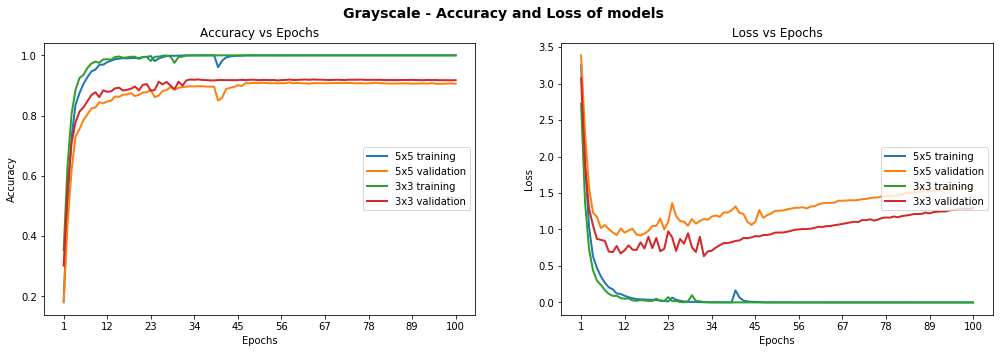

In [33]:
metrics_arr = [g_5x5_tr_metrics, g_5x5_val_metrics, g_3x3_tr_metrics, g_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2,1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"],
                  ["Accuracy vs Epochs", "Loss vs Epochs"], "Grayscale - Accuracy and Loss of models",
                  fig_size = (17,5))

Once again, the 3x3 model outperforms the 5x5 one on validation and test accuracy. We can see that both models' validation losses are increasing as the training accuracy improves. This is a strong suggestion that overfitting is occuring.


### Normalised Images <a name="26"></a>

We now access the model on normalised images, which should presumably allow faster convergence on both training and validation sets

#### Color (Normalised) <a name="27"></a>

In [35]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

me_c_norm_3x3 = ModelExecutor(mc_3x3)
me_c_norm_5x5 = ModelExecutor(mc_5x5)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [36]:
(c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics, c_norm_3x3_duration) = me_c_norm_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_3x3_ts_accuracy, c_norm_3x3_ts_loss, c_norm_3x3_ts_duration) =  me_c_norm_3x3.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=41.399s | train: time=23.068s, loss=1.1973, acc=0.6626 | val: time=18.331s, loss=1.6525, acc=0.5485
[10]	total=45.986s | train: time=24.955s, loss=0.0225, acc=0.9955 | val: time=21.030s, loss=0.4646, acc=0.8980
[20]	total=47.015s | train: time=26.068s, loss=0.0026, acc=0.9999 | val: time=20.948s, loss=0.3724, acc=0.9304
[30]	total=46.199s | train: time=26.185s, loss=0.0005, acc=1.0000 | val: time=20.014s, loss=0.4385, acc=0.9306
[40]	total=44.183s | train: time=24.866s, loss=0.0002, acc=1.0000 | val: time=19.317s, loss=0.4850, acc=0.9322
[50]	total=48.564s | train: time=28.057s, loss=0.0009, acc=1.0000 | val: time=20.507s, loss=0.3468, acc=0.9449
[60]	total=44.436s | train: time=24.096s, loss=0.0001, acc=1.0000 | val: time=20.340s, loss=0.3672, acc=0.9483
[70]	total=46.379s | train: time=25.725s, loss=0.0001, acc=1.0000 | val: time=20.654s, loss=0.4032, acc=0.9476
[80]	total=45.433s | train: time=24.927s, loss=0

In [37]:
(c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_5x5_duration) = me_c_norm_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_5x5_ts_accuracy, c_norm_5x5_ts_loss, c_norm_5x5_ts_duration) =  me_c_norm_5x5.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=56.984s | train: time=29.645s, loss=0.8912, acc=0.7351 | val: time=27.339s, loss=1.2139, acc=0.6458
[10]	total=57.976s | train: time=29.684s, loss=0.0179, acc=0.9968 | val: time=28.292s, loss=0.5479, acc=0.9066
[20]	total=58.376s | train: time=30.975s, loss=0.0016, acc=1.0000 | val: time=27.401s, loss=0.5306, acc=0.9218
[30]	total=56.747s | train: time=29.678s, loss=0.0004, acc=1.0000 | val: time=27.068s, loss=0.5948, acc=0.9231
[40]	total=56.772s | train: time=29.778s, loss=0.0002, acc=1.0000 | val: time=26.994s, loss=0.6517, acc=0.9181
[50]	total=59.740s | train: time=31.094s, loss=0.0001, acc=1.0000 | val: time=28.647s, loss=0.6792, acc=0.9166
[60]	total=57.761s | train: time=30.736s, loss=0.0001, acc=1.0000 | val: time=27.025s, loss=0.6944, acc=0.9193
[70]	total=57.016s | train: time=30.244s, loss=0.0000, acc=1.0000 | val: time=26.773s, loss=0.7294, acc=0.9215
[80]	total=60.982s | train: time=32.914s, loss=0

Length of axis: (2,)


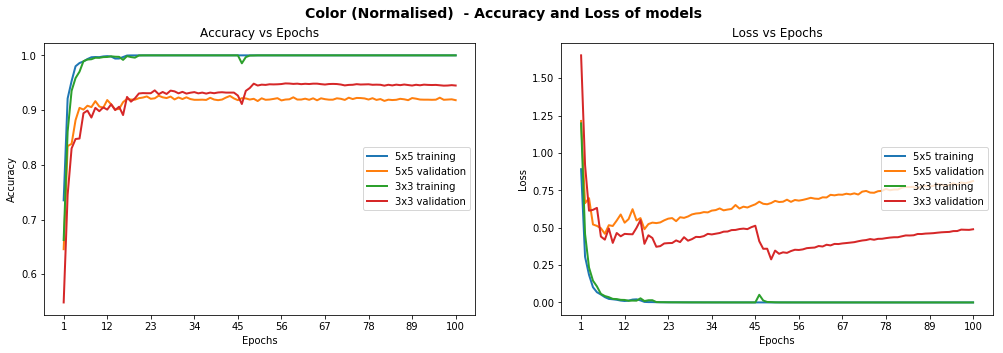

In [38]:
metrics_arr = [c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

The 3x3 still achieve better performance than the 5x5. It can be observed that overfitting happen much more quickly with the 5x5 model. We turn next to grayscale normalised images.

#### Grayscale (Normalised) <a name="28"></a>

In [30]:
# Normalised grayscale images too
X_train_grayscale_normalised = normalise_images(X_train_grayscale, X_train_grayscale)
X_valid_grayscale_normalised = normalise_images(X_valid_grayscale, X_train_grayscale)
X_test_grayscale_normalised = normalise_images(X_test_grayscale, X_train_grayscale)

In [40]:

mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

me_g_norm_3x3 = ModelExecutor(mc_3x3)
me_g_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [41]:
(g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics, g_norm_3x3_duration) = me_g_norm_3x3.train_model(X_train_grayscale_normalised, y_train,
                                                                                                X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_3x3_ts_accuracy, g_norm_3x3_ts_loss, g_norm_3x3_ts_duration) = me_g_norm_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=34.606s | train: time=19.271s, loss=1.7992, acc=0.5243 | val: time=15.336s, loss=2.1431, acc=0.4728
[10]	total=40.895s | train: time=23.738s, loss=0.0349, acc=0.9946 | val: time=17.157s, loss=0.4843, acc=0.8927
[20]	total=40.306s | train: time=22.277s, loss=0.0127, acc=0.9972 | val: time=18.029s, loss=0.5569, acc=0.9070
[30]	total=38.937s | train: time=21.192s, loss=0.0012, acc=1.0000 | val: time=17.745s, loss=0.5338, acc=0.9168
[40]	total=39.508s | train: time=21.744s, loss=0.0005, acc=1.0000 | val: time=17.765s, loss=0.6077, acc=0.9163
[50]	total=38.808s | train: time=21.866s, loss=0.0025, acc=0.9999 | val: time=16.942s, loss=0.3619, acc=0.9349
[60]	total=38.468s | train: time=21.751s, loss=0.0003, acc=1.0000 | val: time=16.716s, loss=0.4357, acc=0.9361
[70]	total=39.112s | train: time=21.820s, loss=0.0002, acc=1.0000 | val: time=17.293s, loss=0.4727, acc=0.9381
[80]	total=39.924s | train: time=22.229s, lo

In [42]:
(g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_5x5_duration) = me_g_norm_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_5x5_ts_accuracy, g_norm_5x5_ts_loss, g_norm_5x5_ts_duration) =  me_g_norm_5x5.test_model(X_test_grayscale_normalised, y_test)


Training EdLeNet_Grayscale_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=47.235s | train: time=26.159s, loss=1.0309, acc=0.7151 | val: time=21.076s, loss=1.3327, acc=0.6431
[10]	total=49.080s | train: time=27.848s, loss=0.0259, acc=0.9950 | val: time=21.232s, loss=0.4537, acc=0.9084
[20]	total=48.933s | train: time=26.449s, loss=0.0130, acc=0.9973 | val: time=22.484s, loss=0.3980, acc=0.9324
[30]	total=48.520s | train: time=26.552s, loss=0.0006, acc=1.0000 | val: time=21.968s, loss=0.4573, acc=0.9336
[40]	total=47.751s | train: time=25.907s, loss=0.0003, acc=1.0000 | val: time=21.844s, loss=0.4928, acc=0.9349
[50]	total=48.980s | train: time=26.844s, loss=0.0002, acc=1.0000 | val: time=22.135s, loss=0.5334, acc=0.9304
[60]	total=48.135s | train: time=26.577s, loss=0.0001, acc=1.0000 | val: time=21.558s, loss=0.5576, acc=0.9333
[70]	total=48.592s | train: time=26.037s, loss=0.0001, acc=1.0000 | val: time=22.555s, loss=0.5842, acc=0.9297
[80]	total=47.961s | train: time=25.905s, lo

Length of axis: (2,)


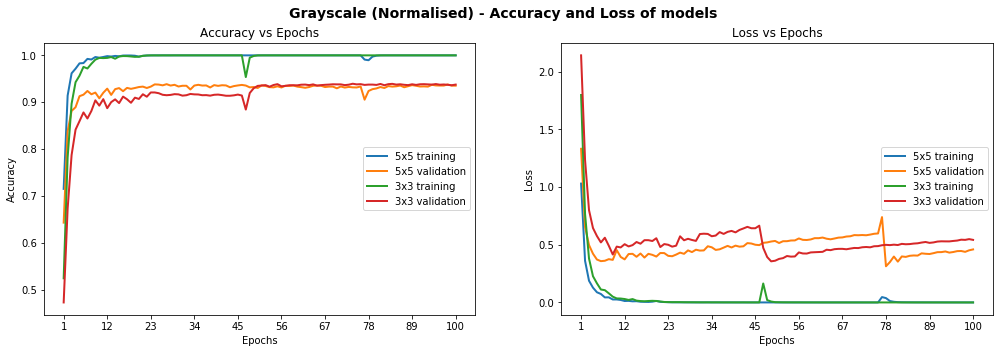

In [43]:
metrics_arr = [g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2,1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"],["Accuracy vs Epochs", "Loss vs Epochs"],
                                                                                       "Grayscale (Normalised) - Accuracy and Loss of models",
                   fig_size = (17,5))

Both models achieve a fair test accuracy at around 92.4%. It's time to try Dropout in our model.

### Dropout - Keep 75% of weights in Fully Connected Layers <a name="29"></a>

Let's start with a keep percentage of 75% to see what kind of results we get. We will also keep weights in the convolutional layers with a probability of 90%

#### Color (Normalised) <a name="30"></a>

In [44]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Dropout_0.75", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Dropout_0.75", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

me_c_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_c_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [45]:
(c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics, c_norm_drpt_0_75_3x3_duration) = me_c_norm_drpt_0_75_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(_c_norm_drpt_0_75_3x3_ts_accuracy, c_norm_drpt_0_75_3x3_ts_loss, c_norm_drpt_0_75_ts_duration) =  me_c_norm_drpt_0_75_3x3.test_model(X_test_normalised, y_test)


Training EdLeNet_3x3_Color_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=42.196s | train: time=23.040s, loss=2.4377, acc=0.3472 | val: time=19.156s, loss=2.5899, acc=0.2776
[10]	total=50.282s | train: time=27.979s, loss=0.0279, acc=0.9949 | val: time=22.303s, loss=0.1528, acc=0.9626
[20]	total=48.222s | train: time=25.345s, loss=0.0044, acc=0.9994 | val: time=22.878s, loss=0.1106, acc=0.9762
[30]	total=46.456s | train: time=26.237s, loss=0.0023, acc=0.9996 | val: time=20.219s, loss=0.1575, acc=0.9703
[40]	total=47.398s | train: time=25.926s, loss=0.0006, acc=0.9999 | val: time=21.472s, loss=0.1255, acc=0.9751
[50]	total=46.833s | train: time=25.483s, loss=0.0005, acc=1.0000 | val: time=21.350s, loss=0.1696, acc=0.9726
[60]	total=45.041s | train: time=24.955s, loss=0.0007, acc=1.0000 | val: time=20.085s, loss=0.1182, acc=0.9751
[70]	total=46.288s | train: time=25.521s, loss=0.0001, acc=1.0000 | val: time=20.767s, loss=0.1119, acc=0.9778
[80]	total=47.650s | train: time=27.202s

In [46]:
(c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_5x5_duration) = me_c_norm_drpt_0_75_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_75_5x5_ts_accuracy, c_norm_drpt_0_75_5x5_ts_loss, c_norm_drpt_0_75_5x5_ts_duration) =  me_c_norm_drpt_0_75_5x5.test_model(X_test_normalised, y_test)

Training EdLeNet_3x3_Color_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=57.557s | train: time=30.841s, loss=2.1590, acc=0.4749 | val: time=26.716s, loss=2.3644, acc=0.3887
[10]	total=58.312s | train: time=29.726s, loss=0.0315, acc=0.9940 | val: time=28.586s, loss=0.2035, acc=0.9492
[20]	total=58.438s | train: time=31.015s, loss=0.0050, acc=0.9992 | val: time=27.424s, loss=0.1510, acc=0.9664
[30]	total=60.212s | train: time=31.818s, loss=0.0020, acc=0.9997 | val: time=28.394s, loss=0.1879, acc=0.9676
[40]	total=59.925s | train: time=30.963s, loss=0.0006, acc=0.9999 | val: time=28.962s, loss=0.1180, acc=0.9739
[50]	total=62.965s | train: time=32.137s, loss=0.0002, acc=1.0000 | val: time=30.828s, loss=0.1482, acc=0.9687
[60]	total=59.157s | train: time=30.773s, loss=0.0003, acc=1.0000 | val: time=28.384s, loss=0.1575, acc=0.9712
[70]	total=59.645s | train: time=31.030s, loss=0.0006, acc=0.9999 | val: time=28.615s, loss=0.1801, acc=0.9710
[80]	total=57.501s | train: time=30.057s

Length of axis: (2,)


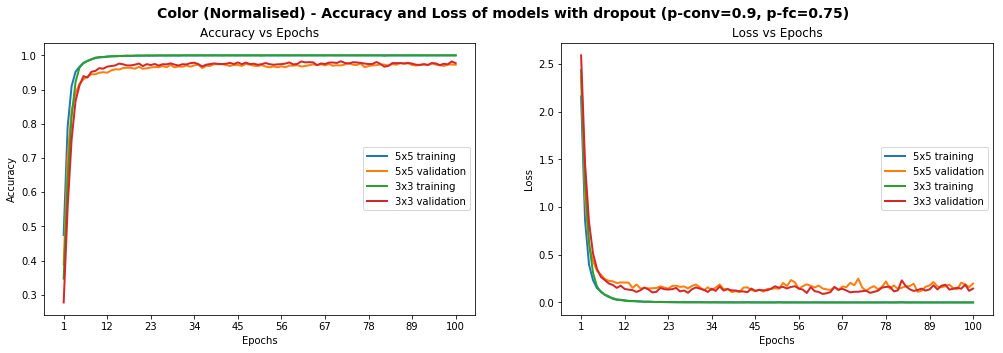

In [47]:
metrics_arr = [c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (Normalised) - Accuracy and Loss of models with dropout (p-conv=0.9, p-fc=0.75)"
                    , fig_size=(17, 5))

We are seeing some great results with the introduction of dropout. The 5x5 model achieves above 96% accuracy while the 3x3 model achieves over 97% test accuracy. We should get similar, if not better results, with grayscale images.

#### Grayscale (Normalised) <a name="31"></a>

In [48]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_3x3_Dropout_0.75", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_5x5_Dropout_0.75", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

me_g_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [50]:
(g_norm_drpt_0_75_3x3_tr_metrics, g_norm_drpt_0_75_3x3_val_metrics, g_norm_drpt_0_75_3x3_duration) = me_g_norm_drpt_0_75_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_75_3x3_ts_accuracy, g_norm_drpt_0_75_3x3_ts_loss, g_norm_drpt_0_75_ts_3x3_duration) = me_g_norm_drpt_0_75_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_3x3_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=35.588s | train: time=19.509s, loss=2.9649, acc=0.2775 | val: time=16.080s, loss=3.1034, acc=0.2549
[10]	total=42.188s | train: time=22.354s, loss=0.0337, acc=0.9935 | val: time=19.834s, loss=0.1455, acc=0.9639
[20]	total=46.187s | train: time=26.593s, loss=0.0059, acc=0.9994 | val: time=19.594s, loss=0.1083, acc=0.9696
[30]	total=47.822s | train: time=25.828s, loss=0.0014, acc=0.9999 | val: time=21.994s, loss=0.0827, acc=0.9796
[40]	total=40.284s | train: time=22.684s, loss=0.0006, acc=1.0000 | val: time=17.599s, loss=0.1078, acc=0.9741
[50]	total=38.752s | train: time=21.277s, loss=0.0003, acc=1.0000 | val: time=17.475s, loss=0.1143, acc=0.9737
[60]	total=39.459s | train: time=21.837s, loss=0.0001, acc=1.0000 | val: time=17.622s, loss=0.1162, acc=0.9755
[70]	total=41.685s | train: time=23.145s, loss=0.0002, acc=1.0000 | val: time=18.541s, loss=0.1068, acc=0.9755
[80]	total=39.434s | train: tim

In [51]:
(g_norm_drpt_0_75_5x5_tr_metrics, g_norm_drpt_0_75_5x5_val_metrics, g_norm_drpt_0_75_5x5_duration) = me_g_norm_drpt_0_75_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_75_5x5_ts_accuracy, g_norm_drpt_0_75_5x5_ts_loss, g_norm_drpt_0_75_ts_5x5_duration) =  me_g_norm_drpt_0_75_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_5x5_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=50.058s | train: time=27.655s, loss=2.0875, acc=0.4843 | val: time=22.403s, loss=2.2733, acc=0.4197
[10]	total=48.092s | train: time=26.364s, loss=0.0380, acc=0.9928 | val: time=21.727s, loss=0.1615, acc=0.9585
[20]	total=51.212s | train: time=28.345s, loss=0.0068, acc=0.9991 | val: time=22.867s, loss=0.1270, acc=0.9692
[30]	total=47.698s | train: time=25.782s, loss=0.0026, acc=0.9997 | val: time=21.916s, loss=0.1094, acc=0.9732
[40]	total=49.959s | train: time=26.877s, loss=0.0008, acc=1.0000 | val: time=23.083s, loss=0.1162, acc=0.9721
[50]	total=48.902s | train: time=26.629s, loss=0.0004, acc=1.0000 | val: time=22.273s, loss=0.1199, acc=0.9728
[60]	total=52.895s | train: time=29.007s, loss=0.0002, acc=1.0000 | val: time=23.888s, loss=0.1340, acc=0.9723
[70]	total=49.596s | train: time=27.602s, loss=0.0002, acc=1.0000 | val: time=21.994s, loss=0.1762, acc=0.9735
[80]	total=52.592s | train: tim

Once again, both 3x3 and 5x5 variants are very close, accuracy-wise on all dataset types. Interestingly, the 3x3 model achieves lower accuracy than its counterpart 3x3 model on color images. We should do more runs of those models to determine which one performs better over the long run in the future. But We believe that we don't need to go that far: we can use even more aggressive dropout values to obtain better results.

### Dropout - Keep 50% of weights in Fully Connected Layers <a name="32"></a>
We will also keep weights in the convolutional layers with a probability of 75%

#### Grayscale (Normalised) <a name="33"></a>

In [52]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Norm_Grayscale_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Norm_Grayscale_5x5_Dropout_0.50", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])
me_g_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [53]:
(g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics, g_norm_drpt_0_50_3x3_duration) = me_g_norm_drpt_0_50_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_50_3x3_ts_accuracy, g_norm_drpt_0_50_3x3_ts_loss, g_norm_drpt_0_50_ts_3x3_duration) =  me_g_norm_drpt_0_50_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Norm_Grayscale_3x3_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=45.027s | train: time=24.774s, loss=3.4726, acc=0.1258 | val: time=20.253s, loss=3.5255, acc=0.1098
[10]	total=41.068s | train: time=23.038s, loss=0.2596, acc=0.9259 | val: time=18.029s, loss=0.3627, acc=0.8857
[20]	total=42.559s | train: time=22.904s, loss=0.0556, acc=0.9890 | val: time=19.655s, loss=0.1176, acc=0.9687
[30]	total=41.826s | train: time=22.959s, loss=0.0197, acc=0.9968 | val: time=18.867s, loss=0.0872, acc=0.9755
[40]	total=41.952s | train: time=23.596s, loss=0.0083, acc=0.9988 | val: time=18.355s, loss=0.0631, acc=0.9828
[50]	total=39.539s | train: time=21.509s, loss=0.0041, acc=0.9994 | val: time=18.029s, loss=0.0537, acc=0.9848
[60]	total=38.965s | train: time=21.029s, loss=0.0024, acc=0.9995 | val: time=17.936s, loss=0.0540, acc=0.9866
[70]	total=38.270s | train: time=20.961s, loss=0.0016, acc=0.9996 | val: time=17.309s, loss=0.0449, acc=0.9887
[80]	total=38.992s | train: tim

In [54]:
(g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_5x5_duration) = me_g_norm_drpt_0_50_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_50_5x5_ts_accuracy, g_norm_drpt_0_50_5x5_ts_loss, g_norm_drpt_0_50_ts_5x5_duration) =  me_g_norm_drpt_0_50_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Norm_Grayscale_5x5_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=48.281s | train: time=26.929s, loss=3.4394, acc=0.1497 | val: time=21.352s, loss=3.4888, acc=0.1175
[10]	total=48.725s | train: time=25.816s, loss=0.2477, acc=0.9434 | val: time=22.908s, loss=0.3471, acc=0.9054
[20]	total=51.980s | train: time=29.581s, loss=0.0589, acc=0.9897 | val: time=22.399s, loss=0.1305, acc=0.9639
[30]	total=48.155s | train: time=26.025s, loss=0.0185, acc=0.9969 | val: time=22.130s, loss=0.0865, acc=0.9712
[40]	total=47.690s | train: time=25.372s, loss=0.0099, acc=0.9984 | val: time=22.318s, loss=0.0842, acc=0.9717
[50]	total=48.849s | train: time=26.799s, loss=0.0053, acc=0.9991 | val: time=22.050s, loss=0.0652, acc=0.9805
[60]	total=52.998s | train: time=28.334s, loss=0.0036, acc=0.9995 | val: time=24.664s, loss=0.0781, acc=0.9787
[70]	total=50.293s | train: time=27.129s, loss=0.0024, acc=0.9996 | val: time=23.165s, loss=0.0853, acc=0.9798
[80]	total=51.089s | train: tim

Length of axis: (2,)


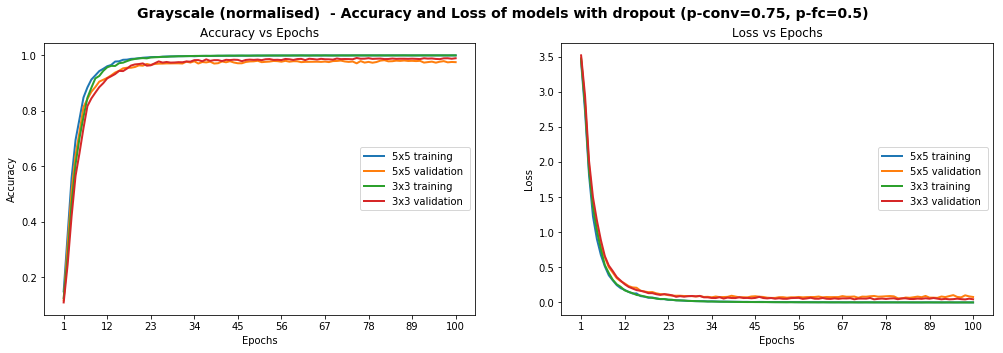

In [55]:
metrics_arr = [g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (normalised)  - Accuracy and Loss of models with dropout (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

Both models show smooth, satisfying on the curves. The 3x3 model clearly seems to perform the best. While we are able to score above 98% accuracy on vaidation set, we have not been able to break through this barrier yet on the test set, but we are close!

#### Color (Normalised) <a name="33"></a>

In [56]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_3x3_Dropout_0.40", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_5x5_Dropout_0.40", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

me_c_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
me_c_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5, learning_rate=0.001)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [57]:
(c_norm_drpt_0_50_3x3_tr_metrics, c_norm_drpt_0_50_3x3_val_metrics, c_norm_drpt_0_50_3x3_duration) = me_c_norm_drpt_0_50_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_50_3x3_ts_accuracy, c_norm_drpt_0_50_3x3_ts_loss, c_norm_drpt_0_50_3x3_ts_duration) =  me_c_norm_drpt_0_50_3x3.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_3x3_Dropout_0.40 [epochs=100, batch_size=512]...

[1]	total=52.498s | train: time=29.755s, loss=3.4158, acc=0.1989 | val: time=22.743s, loss=3.4510, acc=0.2079
[10]	total=45.359s | train: time=25.617s, loss=0.3766, acc=0.8948 | val: time=19.743s, loss=0.5358, acc=0.8549
[20]	total=46.548s | train: time=26.558s, loss=0.0663, acc=0.9875 | val: time=19.990s, loss=0.1619, acc=0.9621
[30]	total=46.319s | train: time=25.537s, loss=0.0169, acc=0.9967 | val: time=20.782s, loss=0.1049, acc=0.9710
[40]	total=45.452s | train: time=24.851s, loss=0.0077, acc=0.9988 | val: time=20.601s, loss=0.0871, acc=0.9769
[50]	total=47.047s | train: time=26.434s, loss=0.0036, acc=0.9994 | val: time=20.612s, loss=0.0712, acc=0.9832
[60]	total=46.966s | train: time=25.262s, loss=0.0022, acc=0.9997 | val: time=21.704s, loss=0.0838, acc=0.9814
[70]	total=46.192s | train: time=25.421s, loss=0.0010, acc=0.9999 | val: time=20.771s, loss=0.0707, acc=0.9844
[80]	total=46.117s | train: time=25

In [58]:
(c_norm_drpt_0_50_5x5_tr_metrics, c_norm_drpt_0_50_5x5_val_metrics, c_norm_drpt_0_50_5x5_duration) = me_c_norm_drpt_0_50_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_50_5x5_ts_accuracy, c_norm_drpt_0_50_5x5_ts_loss, c_norm_drpt_0_50_5x5_ts_duration) =  me_c_norm_drpt_0_50_5x5.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_5x5_Dropout_0.40 [epochs=100, batch_size=512]...

[1]	total=56.877s | train: time=29.760s, loss=3.3506, acc=0.2254 | val: time=27.116s, loss=3.4003, acc=0.1968
[10]	total=58.388s | train: time=29.984s, loss=0.3224, acc=0.9346 | val: time=28.404s, loss=0.4422, acc=0.8816
[20]	total=58.727s | train: time=30.766s, loss=0.0550, acc=0.9895 | val: time=27.961s, loss=0.1565, acc=0.9601
[30]	total=58.596s | train: time=30.105s, loss=0.0208, acc=0.9973 | val: time=28.490s, loss=0.1257, acc=0.9705
[40]	total=58.594s | train: time=29.757s, loss=0.0092, acc=0.9986 | val: time=28.837s, loss=0.1086, acc=0.9744
[50]	total=59.422s | train: time=31.234s, loss=0.0048, acc=0.9993 | val: time=28.188s, loss=0.1193, acc=0.9737
[60]	total=60.263s | train: time=31.436s, loss=0.0027, acc=0.9996 | val: time=28.828s, loss=0.1060, acc=0.9814
[70]	total=58.831s | train: time=30.739s, loss=0.0024, acc=0.9997 | val: time=28.092s, loss=0.1233, acc=0.9719
[80]	total=57.663s | train: time=30

Length of axis: (2,)


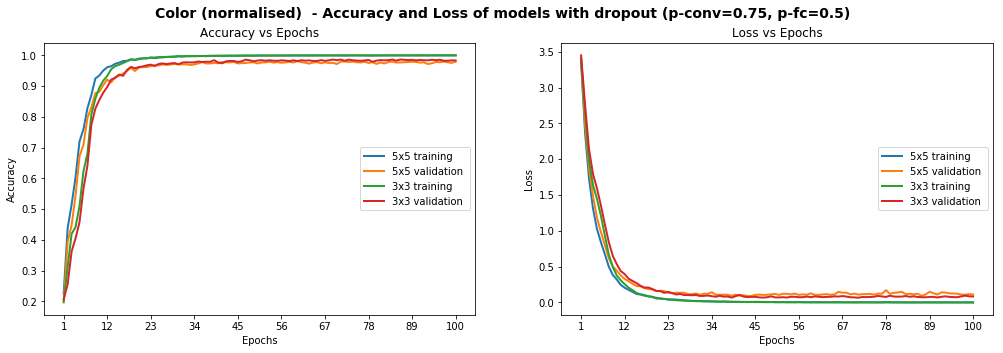

In [59]:
metrics_arr = [c_norm_drpt_0_50_5x5_tr_metrics, c_norm_drpt_0_50_5x5_val_metrics, c_norm_drpt_0_50_3x3_tr_metrics, c_norm_drpt_0_50_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (normalised)  - Accuracy and Loss of models with dropout (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

Color and grayscale images exhibit very similar behaviour, with maybe the advantage for grayscale, lower losses on test accuracy. At this stage we are unable to pick between grayscale or color for the input images since we obtain very similar results in both cases. Maybe color is not much of an issue in fact if the model performs so well on grayscale images? We will next turn to augmenting images and explore whether we can reach better results by randomly applying distortions to our images.

## 4. Histogram Equalization <a name="35"></a>

We observed earlier that some of the images in the dataset were quite dark, and others blurry. We are aiming at taclking this problem in this part where we attempt to apply histogram equalization techniques to improve the contrast of our images and therefore make it easier for our model to discern which class the supplied image ultimately belongs to with a higher level of confidence. To do so, we are going to rely on OpenCV's CLAHE (Contrast Limiting Adaptive Histogram Equalization) function.

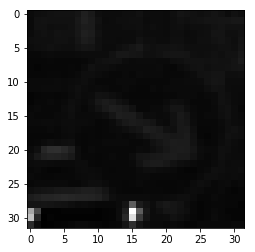

In [31]:
g_img = np.reshape(X_train_grayscale[15796], (32, 32))
plt.imshow(g_img, cmap='gray')

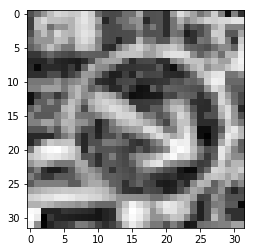

In [32]:
clahe = cv2.createCLAHE(tileGridSize=(4,4), clipLimit=40.0)
cl1 = clahe.apply(g_img)
plt.imshow(cl1, cmap='gray')

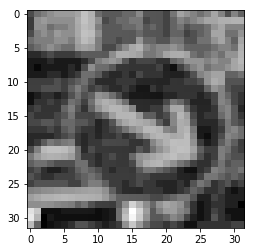

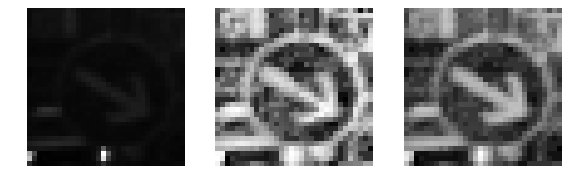

In [33]:
clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=15.0)
cl2 = clahe.apply(g_img)
plt.imshow(cl2, cmap='gray')
show_image_list([g_img, cl1, cl2], ["L0", "L1", "L2"], "", cols=3, fig_size=(8,8), show_ticks=False)

We choose CLAHE with grid size of 2x2 and climit limit of 15

In [34]:
X_train_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32,32))), 
                                                  X_train_grayscale)))
X_valid_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))),
                                                  X_valid_grayscale)))
X_test_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))),
                                                 X_test_grayscale)))

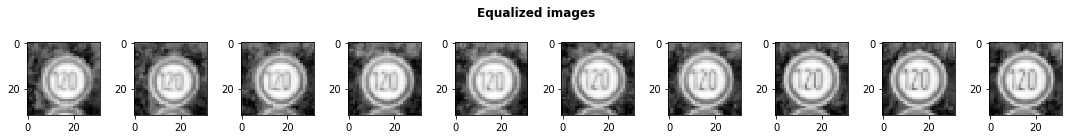

In [35]:
show_image_list(X_train_grayscale_equalized[16000:16010], y_train[16000:16010], "Equalized images",
               fig_size=(15,10), cols=10, show_ticks=True)

### Model evaluation <a name="36"></a>

In [36]:
# Let's normalize our images beforehand
X_train_grayscale_equalized_normalised = normalise_images(X_train_grayscale_equalized, X_train_grayscale_equalized)
X_valid_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_grayscale_equalized)
X_test_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_grayscale_equalized)

In [37]:
# Reshape our images
X_train_grayscale_equalized = np.reshape(X_train_grayscale_equalized, (X_train_grayscale_equalized.shape[0], 32, 32, 1))
X_valid_grayscale_equalized = np.reshape(X_valid_grayscale_equalized, (X_valid_grayscale_equalized.shape[0], 32, 32, 1))
X_test_grayscale_equalized = np.reshape(X_test_grayscale_equalized, (X_test_grayscale_equalized.shape[0], 32, 32, 1))

X_train_grayscale_equalized_normalised = np.reshape(X_train_grayscale_equalized_normalised, (X_train_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_grayscale_equalized_normalised = np.reshape(X_valid_grayscale_equalized_normalised, (X_valid_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_grayscale_equalized_normalised = np.reshape(X_test_grayscale_equalized_normalised, (X_test_grayscale_equalized_normalised.shape[0], 32, 32, 1))

#### Normalise images with No Dropout <a name="37"></a>

In [92]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], 
                     n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], 
                     n_classes, [1.0, 1.0])

In [93]:
me_g_clahe_norm_3x3 = ModelExecutor(mc_3x3)
me_g_clahe_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [94]:
(g_clage_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics, g_clahe_norm_3x3_duration) = \
me_g_clahe_norm_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs =100)

(g_clahe_norm_3x3_ts_accuracy, g_clahe_norm_3x3_ts_loss, g_clahe_norm_3x3_ts_duration) =  \
me_g_clahe_norm_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=34.639s | train: time=19.635s, loss=1.0549, acc=0.6691 | val: time=15.004s, loss=1.3020, acc=0.5932
[10]	total=38.981s | train: time=21.822s, loss=0.0162, acc=0.9976 | val: time=17.159s, loss=0.2023, acc=0.9420
[20]	total=39.739s | train: time=22.161s, loss=0.0011, acc=1.0000 | val: time=17.578s, loss=0.2441, acc=0.9483
[30]	total=39.269s | train: time=22.314s, loss=0.0003, acc=1.0000 | val: time=16.955s, loss=0.2655, acc=0.9485
[40]	total=42.602s | train: time=23.352s, loss=0.0002, acc=1.0000 | val: time=19.250s, loss=0.2807, acc=0.9506
[50]	total=41.580s | train: time=23.298s, loss=0.0001, acc=1.0000 | val: time=18.282s, loss=0.2912, acc=0.9508
[60]	total=39.058s | train: time=21.844s, loss=0.0000, acc=1.0000 | val: time=17.214s, loss=0.3057, acc=0.9508
[70]	total=39.917s | train: time=22.540s, loss=0.0000, acc=1.0000 | val: time=17.377s, loss=0.3190, acc=0.9488
[80]	total=39.272s | train: time=21.27

In [96]:
(g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_5x5_duration) = \
me_g_clahe_norm_5x5.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)

(g_clahe_norm_5x5_ts_accuracy, g_clahe_norm_5x5_ts_loss, g_clahe_norm_5x5_ts_duration) = \
me_g_clahe_norm_5x5.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=42.298s | train: time=23.498s, loss=0.6959, acc=0.7962 | val: time=18.799s, loss=0.9005, acc=0.7304
[10]	total=48.425s | train: time=26.516s, loss=0.0224, acc=0.9940 | val: time=21.909s, loss=0.2995, acc=0.9220
[20]	total=47.443s | train: time=26.236s, loss=0.0009, acc=1.0000 | val: time=21.207s, loss=0.3004, acc=0.9376
[30]	total=48.217s | train: time=26.429s, loss=0.0003, acc=1.0000 | val: time=21.788s, loss=0.3215, acc=0.9395
[40]	total=48.477s | train: time=26.760s, loss=0.0001, acc=1.0000 | val: time=21.718s, loss=0.3450, acc=0.9397
[50]	total=48.989s | train: time=25.940s, loss=0.0001, acc=1.0000 | val: time=23.049s, loss=0.3595, acc=0.9420
[60]	total=48.385s | train: time=26.436s, loss=0.0000, acc=1.0000 | val: time=21.949s, loss=0.3703, acc=0.9415
[70]	total=47.887s | train: time=25.839s, loss=0.0000, acc=1.0000 | val: time=22.048s, loss=0.3896, acc=0.9399
[80]	total=47.611s | train: time=25.59

Length of axis: (2,)


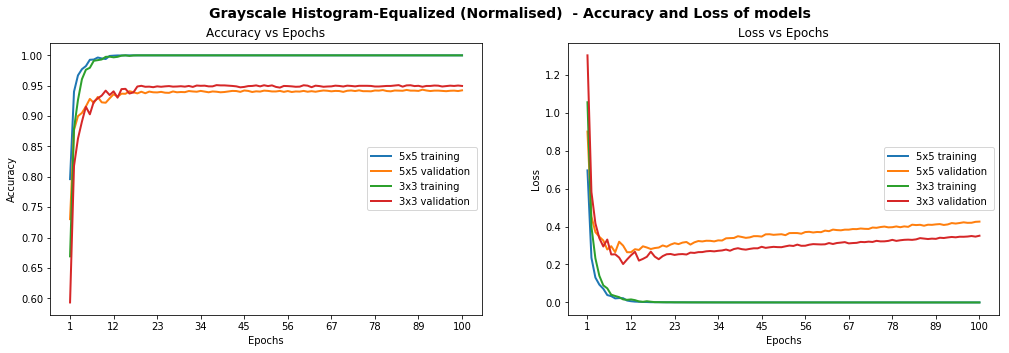

In [97]:
metrics_arr = [g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clage_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale Histogram-Equalized (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

The 3x3 model performs better, topping 93% test accuracy, but we can see on the graph of Loss vs Epochs that our models losses increase as the epochs go by, which would indicate that we are overfitting and no working hard enough to extract features that generalise. We will try applying aggressive dropout values, with the hope that this helps alleviate the loss and improve the accuracy.

#### Normalised images With Dropout <a name="38"></a>

We apply our best model with two levels of dropout (p-conv=0.5, p-fc=0.5)) and (p-conv=0.6, p-fc=0.5) on normalised histogram-equalised image

In [98]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32,32,1], [3,32,3], [120, 84],
                    n_classes, [0.5, 0.5])
me_g_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [99]:
(g_clahe_norm_drpt_0_50_3x3_tr_metrics, g_clahe_norm_drpt_0_50_3x3_val_metrics, g_clahe_norm_drpt_0_50_3x3_duration) = \
me_g_clahe_norm_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=500)

(g_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_drpt_0_50_3x3_ts_loss, g_clahe_norm_drpt_0_50_ts_3x3_duration) =  \
me_g_clahe_norm_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 [epochs=500, batch_size=512]...

[1]	total=39.306s | train: time=21.746s, loss=3.6715, acc=0.0570 | val: time=17.559s, loss=3.6844, acc=0.0580
[10]	total=38.426s | train: time=21.429s, loss=1.3966, acc=0.5767 | val: time=16.997s, loss=1.4792, acc=0.5544
[20]	total=38.929s | train: time=21.143s, loss=0.5199, acc=0.8293 | val: time=17.786s, loss=0.5687, acc=0.8195
[30]	total=38.805s | train: time=21.576s, loss=0.2791, acc=0.9035 | val: time=17.229s, loss=0.2984, acc=0.8855
[40]	total=38.638s | train: time=21.603s, loss=0.1759, acc=0.9478 | val: time=17.036s, loss=0.1987, acc=0.9336
[50]	total=38.526s | train: time=21.421s, loss=0.1067, acc=0.9740 | val: time=17.105s, loss=0.1314, acc=0.9626
[60]	total=38.526s | train: time=20.853s, loss=0.0623, acc=0.9889 | val: time=17.673s, loss=0.0892, acc=0.9773
[70]	total=37.888s | train: time=20.255s, loss=0.0441, acc=0.9919 | val: time=17.633s, loss=0.0759, acc=0.9776
[80]	total=39.051s | trai

In [28]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50", [32, 32, 1],
                     [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])

me_g_clahe_norm_take2_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [38]:
(g_clahe_norm_take2_drpt_0_50_3x3_tr_metrics, g_clahe_norm_take2_drpt_0_50_3x3_val_metrics, g_clahe_norm_take2_drpt_0_50_3x3_duration) =\
me_g_clahe_norm_take2_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=500)

(g_clahe_norm_take2_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_take2_drpt_0_50_3x3_ts_loss,    g_clahe_norm_take2_drpt_0_50_ts_3x3_duration) =\
me_g_clahe_norm_take2_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50 [epochs=500, batch_size=512]...

[1]	total=34.646s | train: time=19.719s, loss=3.6309, acc=0.0778 | val: time=14.926s, loss=3.6503, acc=0.0571
[10]	total=37.052s | train: time=20.379s, loss=0.7877, acc=0.7475 | val: time=16.673s, loss=0.8475, acc=0.7197
[20]	total=39.355s | train: time=21.661s, loss=0.2609, acc=0.9030 | val: time=17.694s, loss=0.2991, acc=0.8871
[30]	total=38.537s | train: time=20.935s, loss=0.1297, acc=0.9481 | val: time=17.602s, loss=0.1638, acc=0.9329
[40]	total=38.243s | train: time=20.977s, loss=0.0552, acc=0.9898 | val: time=17.266s, loss=0.0908, acc=0.9805
[50]	total=38.079s | train: time=20.726s, loss=0.0238, acc=0.9955 | val: time=17.354s, loss=0.0616, acc=0.9825
[60]	total=39.196s | train: time=21.790s, loss=0.0152, acc=0.9974 | val: time=17.406s, loss=0.0594, acc=0.9834
[70]	total=39.499s | train: time=21.400s, loss=0.0120, acc=0.9975 | val: time=18.100s, loss=0.0454, acc=0.9884
[80]	total=38.961s

**The 3x3 CLAHE - Take 2- achieves a remarkable 97.71% accuracy with loss score under 0.1. That is so far our best model.**


### Analysis of 3x3 Model performance <a name="39"></a>


In [39]:
test_preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(X_test_grayscale_equalized_normalised)


INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [40]:
good_test_preds = test_preds == y_test
bad_test_preds = test_preds != y_test

In [41]:
bad_test_pred_imgs = X_test_grayscale_equalized[bad_test_preds]
good_test_pred_imgs = X_test_grayscale_equalized[good_test_preds]
bad_test_pred_correct_lb = y_test[bad_test_preds]
bad_test_pred_incorrect_lb = test_preds[bad_test_preds]

In [42]:
print("Number of good predictions: {0}/{1}".format(len(good_test_pred_imgs), len(y_test)))
print("Number of bad predictions: {0}/{1}".format(len(bad_test_pred_imgs), len(y_test)))

Number of good predictions: 12340/12630
Number of bad predictions: 290/12630


We have 290 images where our prediction was incorrect. Let's visualize some of them to better understand what's going on.

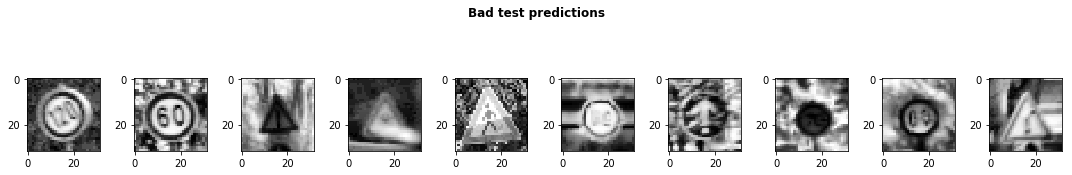

In [43]:
count =10
idx = np.random.randint(0, high=len(bad_test_pred_imgs), size=10)
show_image_list(bad_test_pred_imgs[idx], bad_test_pred_incorrect_lb, "Bad test predictions", cols = count)

Some of the images are very blurry, despite our histogram equalization, while others seem distorted. We turn to data augmentation to address these isssues.

## 5. Data Augmentation <a name="40"></a>

We observed earlier that the data presented glaring imbalance across the 43 classes. Yet it does not seem to be a crippling problem as we are able to reach very high accuracy despite the class imbalance. We also noticed that some images in the test set are distorted. We are therefore going to use data augmentation techniques in an attempt to:

   1. Minimize imbalances across classes
   2. Extend dataset and provide additional pictures in different lighting settings and orientations
   3. Improve model's ability to become more generic
   4. Improve test and validation accuracy, especially on distorted images



In [44]:
X_train_augs = X_train
y_train_augs = y_train

In [45]:
# This loop augments images per label group
for (lid, lbl), group in X_train_group_by_label:
    #print((lid, lbl))
    #print(group)
    group_count = group['img_id'].size
    idx = group['img_id'].values
    imgs = X_train[idx]
    
    
    # Take a different population of the subset depending on how many images we have already
    # and vary the number of augmentations depending on size of label group
    pt_spacing = 1.0
    p = 1.0
    n = group_count * 0.1 # augment 10% of the images in that label group
    
    if group_count > 500 and group_count < 1000:
        pt_spacing = 3.0
    elif group_count >= 1000 and group_count < 2000:
        pt_spacing = 10.0
        
    elif group_count >= 2000:
        pt_spacing = 20.0
        
    n = int(n)
    
    space_interval = int(group_count / pt_spacing)
    rand_idx = np.linspace(0, group_count, num=space_interval, endpoint=False, dtype='int')
    selected_rows = group.iloc[rand_idx]
    selected_img = np.array(list(map(lambda img_id: X_train[img_id], selected_rows['img_id'])))
    augs = augment_imgs_until_n(selected_img, n, p)
    X_train_augs = np.concatenate((X_train_augs, augs)) # Add the augmented training images to the original training images
    y_train_augs = np.concatenate((y_train_augs, np.repeat(lid, n))) # Add labels to augmented training images

print("Original training array shape: {0} and {1}".format(X_train.shape, y_train.shape))
print("New Augmented array shape: {0} and {1}".format(X_train_augs.shape, y_train_augs.shape))

Original training array shape: (34799, 32, 32, 3) and (34799,)
New Augmented array shape: (38278, 32, 32, 3) and (38278,)


Let's see the distribution and visualize some random images from the new augmented set: 

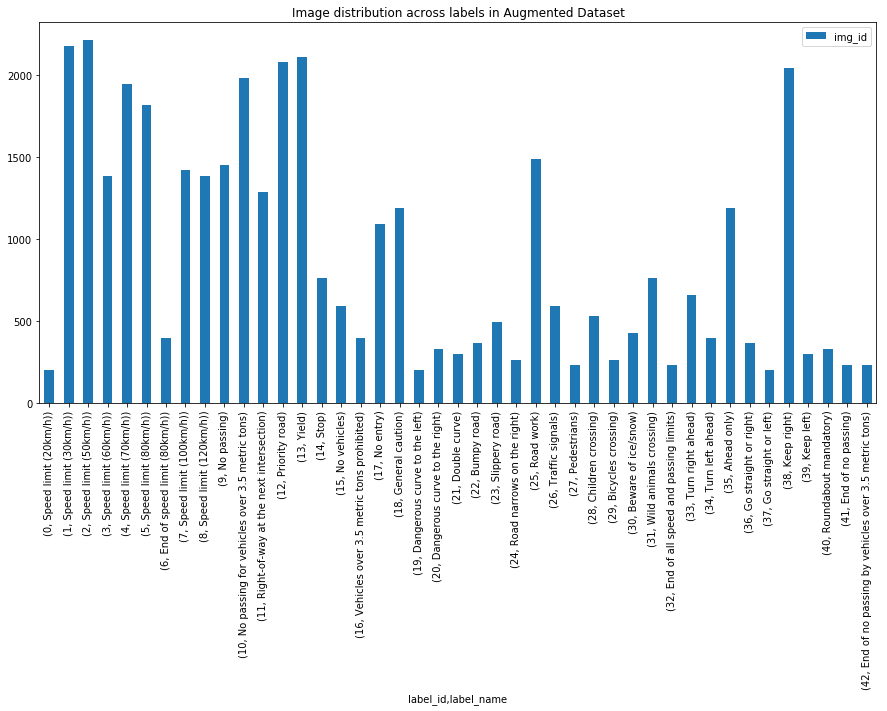

In [46]:
X_train_augs_id_to_label = group_img_id_to_lbl(y_train_augs, sign_names)
X_train_augs_group_by_label_count = group_img_id_to_lb_count(X_train_augs_id_to_label)

# Now count the number of images for each class and plot the results so taht we understand the distribution
X_train_augs_group_by_label_count.plot(kind='bar', figsize=(15,7), title="Image distribution across labels \
in Augmented Dataset")

We have managed to mitigate the gaping imbalance we originally observed, but it is still painfully obvious. We decided to temper our augmentation ambitions as we did not want the model to overwhelmingly learn about augmented images, to the detriment of real images. That's a hard balance to strike in all fairness but we believe we have some interesting results. Now every class has at least 10% of its dataset augmented. Our assumption is that our network should now perform better. Let's put it to the test. The below shows visuals of the new dataset, with some images having been augmented by the steps above.

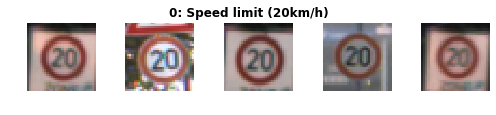

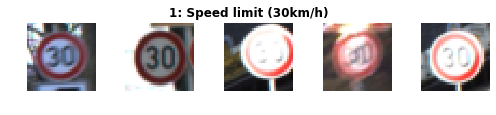

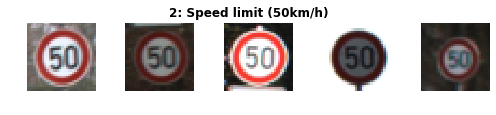

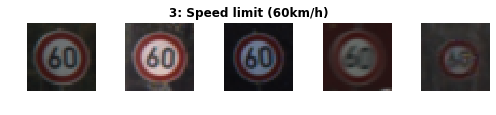

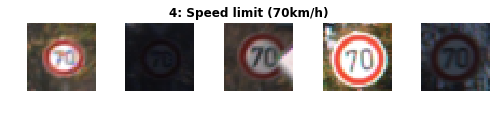

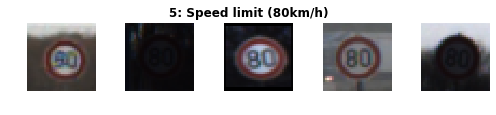

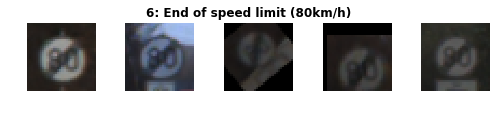

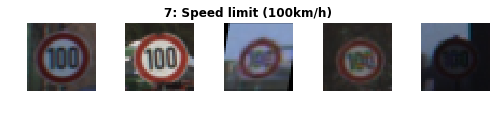

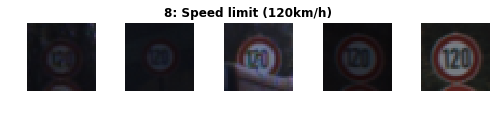

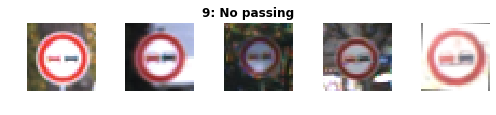

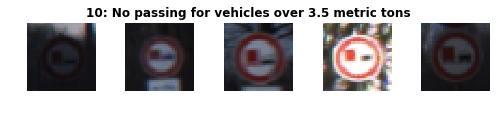

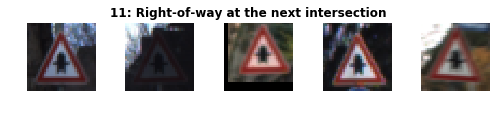

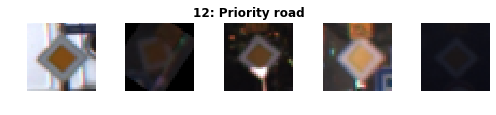

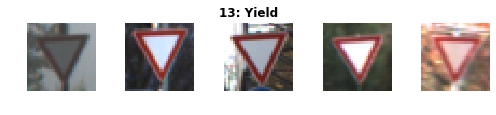

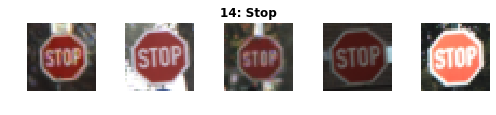

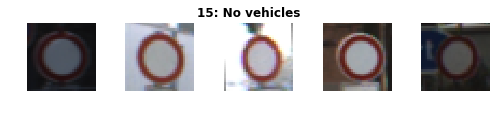

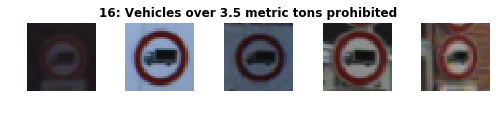

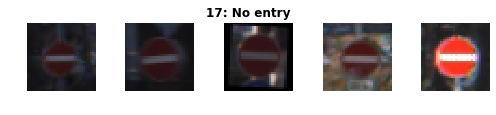

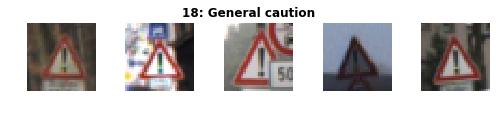

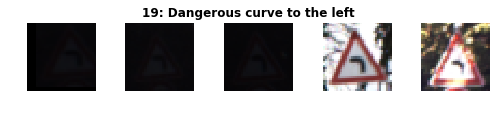

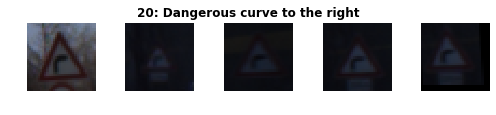

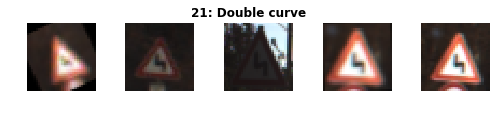

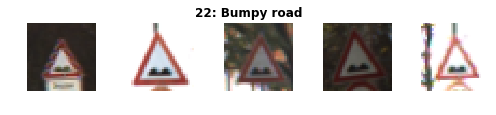

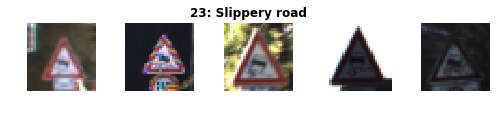

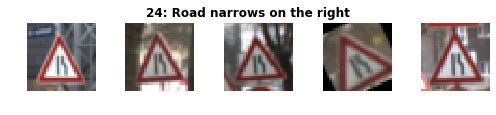

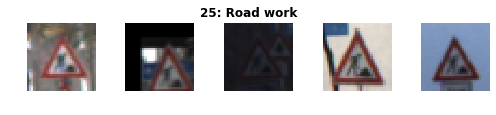

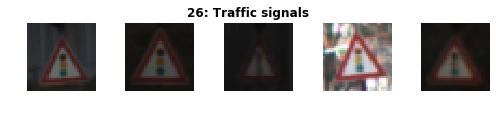

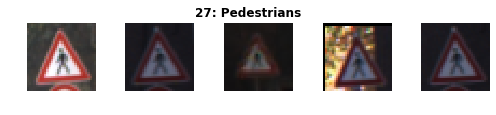

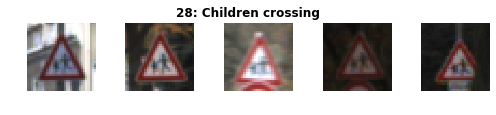

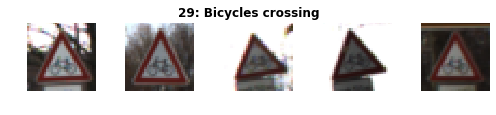

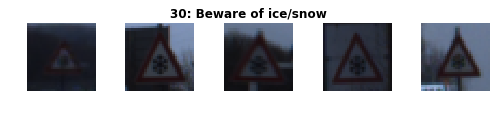

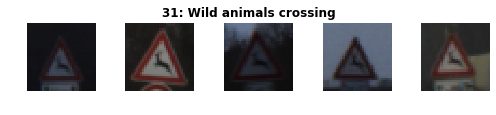

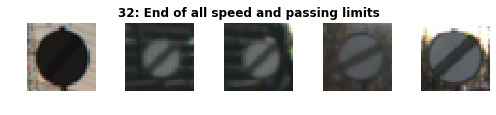

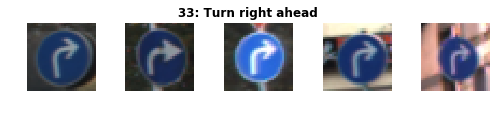

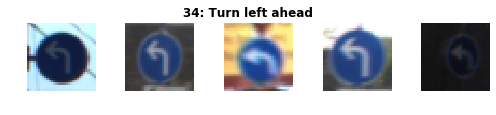

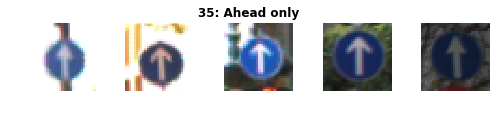

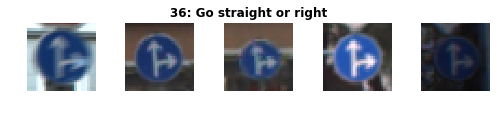

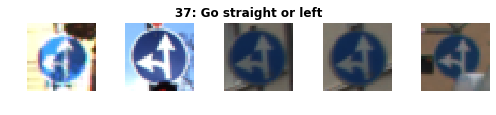

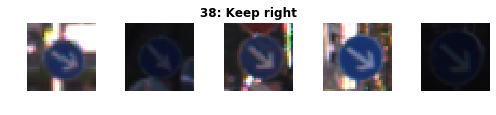

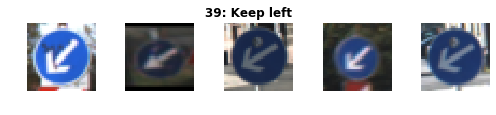

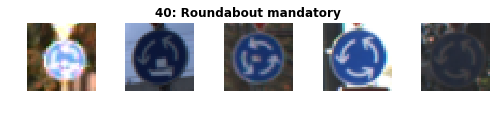

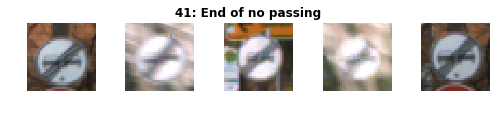

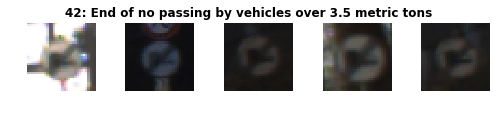

In [47]:
# Let's plot images from each of these classes
X_train_augs_group_by_label = X_train_augs_id_to_label.groupby(["label_id", "label_name"])
show_random_datasets_images(X_train_augs_group_by_label, X_train_augs)

### Evaluating model on augmented dataset  <a name="42"></a>

For this part, we will focus exclusively on grayscale images as they seem to produce better performance. Color images may exhibit close performance but as we plan to also apply histogram equalization the images must be in grayscale.

#### Grayscale Augmented Dataset  <a name="42"></a>

In [57]:
# First convert to grayscale
X_train_augs_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train_augs)))

In [58]:
# Then histogram equalize the grayscale images
X_train_augs_grayscale_equalized = \
np.asarray(list(map(lambda img: clahe.apply(np.reshape(img,(32,32))), X_train_augs_grayscale)))

In [59]:
# Now normalise using the mean and std of the training set
X_train_augs_grayscale_equalized_normalised = \
normalise_images(X_train_augs_grayscale_equalized, X_train_augs_grayscale_equalized)
X_valid_augs_grayscale_equalized_normalised = \
normalise_images(X_valid_grayscale_equalized, X_train_augs_grayscale_equalized)
X_test_augs_grayscale_equalized_normalised = \
normalise_images(X_test_grayscale_equalized, X_train_augs_grayscale_equalized)

In [60]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_augs_grayscale_equalized_normalised = \
np.reshape(X_train_augs_grayscale_equalized_normalised, (X_train_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_augs_grayscale_equalized_normalised = \
np.reshape(X_valid_augs_grayscale_equalized_normalised, (X_valid_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_augs_grayscale_equalized_normalised = \
np.reshape(X_test_augs_grayscale_equalized_normalised,   (X_test_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))



#### No Dropout  <a name="43"></a>

In [157]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], 
                     n_classes, [1.0, 1.0])
me_g_augs_clahe_norm_3x3 = ModelExecutor(mc_3x3)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [158]:
(g_augs_clahe_norm_3x3_tr_metrics,  g_augs_clahe_norm_3x3_val_metrics, g_augs_clahe_norm_3x3_duration) = \
me_g_augs_clahe_norm_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=50, batch_size=4096)

Training EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3 [epochs=50, batch_size=4096]...

[1]	total=40.887s | train: time=22.892s, loss=3.3775, acc=0.1486 | val: time=17.995s, loss=3.4612, acc=0.1150
[10]	total=46.085s | train: time=25.264s, loss=0.6024, acc=0.8342 | val: time=20.820s, loss=0.7077, acc=0.7819
[20]	total=46.418s | train: time=25.296s, loss=0.2767, acc=0.9333 | val: time=21.123s, loss=0.3850, acc=0.8853
[30]	total=46.823s | train: time=25.033s, loss=0.1656, acc=0.9607 | val: time=21.790s, loss=0.3107, acc=0.9070
[40]	total=46.536s | train: time=25.869s, loss=0.1096, acc=0.9753 | val: time=20.667s, loss=0.3122, acc=0.9109
[50]	total=46.452s | train: time=25.702s, loss=0.0661, acc=0.9862 | val: time=20.751s, loss=0.2982, acc=0.9175
Model ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3.chkpt saved


In [159]:
(g_augs_clahe_norm_3x3_ts_accuracy, g_augs_clahe_norm_3x3_ts_loss, g_augs_clahe_norm_3x3_ts_duration) =  \
me_g_augs_clahe_norm_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3 - Test set]	 time=6.271s, loss=0.3832, acc=0.9024


We only ran 50 epochs this time and the results look very encouraging. Let's now try more aggressive values for dropout to see how the model adapts.

#### Dropout - Keep Fully Connected Layer Weights with p = 0.5  <a name="44"></a>

#### *TAKE1: dropout (p-conv=0.7, p-fc=0.5)*   <a name="45"></a>

In [54]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32,32,1],[3,32,3],
                    [120,84], n_classes, [0.7, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [62]:
(g_augs_clahe_norm_dropt_0_50_3x3_tr_metrics, g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, 
 g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised,
                                                                                           y_train_augs, X_valid_augs_grayscale_equalized_normalised,
                                                                                           y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss, 
 g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

Training EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 [epochs=900, batch_size=512]...

[1]	total=38.539s | train: time=22.013s, loss=3.5414, acc=0.1135 | val: time=16.526s, loss=3.5740, acc=0.1120
[10]	total=44.057s | train: time=24.656s, loss=0.5302, acc=0.8291 | val: time=19.401s, loss=0.5057, acc=0.8240
[20]	total=45.532s | train: time=25.723s, loss=0.1944, acc=0.9288 | val: time=19.810s, loss=0.1697, acc=0.9354
[30]	total=47.446s | train: time=25.479s, loss=0.0860, acc=0.9763 | val: time=21.968s, loss=0.0755, acc=0.9757
[40]	total=43.166s | train: time=23.977s, loss=0.0501, acc=0.9865 | val: time=19.189s, loss=0.0557, acc=0.9853
[50]	total=45.246s | train: time=25.892s, loss=0.0357, acc=0.9902 | val: time=19.354s, loss=0.0400, acc=0.9875
[60]	total=43.644s | train: time=23.996s, loss=0.0260, acc=0.9930 | val: time=19.647s, loss=0.0350, acc=0.9889
[70]	total=43.717s | train: time=24.247s, loss=0.0190, acc=0.9947 | val: time=19.471s, loss=0.0367, acc=0.9887
[80]	total=47.927s |

[730]	total=43.571s | train: time=23.372s, loss=0.0004, acc=1.0000 | val: time=20.199s, loss=0.0267, acc=0.9925
[740]	total=42.162s | train: time=23.098s, loss=0.0003, acc=1.0000 | val: time=19.064s, loss=0.0261, acc=0.9932
[750]	total=42.586s | train: time=23.264s, loss=0.0004, acc=0.9999 | val: time=19.323s, loss=0.0308, acc=0.9909
[760]	total=42.231s | train: time=23.766s, loss=0.0003, acc=1.0000 | val: time=18.464s, loss=0.0358, acc=0.9907
[770]	total=42.301s | train: time=23.745s, loss=0.0003, acc=1.0000 | val: time=18.556s, loss=0.0299, acc=0.9914
[780]	total=42.151s | train: time=23.207s, loss=0.0003, acc=1.0000 | val: time=18.944s, loss=0.0299, acc=0.9902
[790]	total=42.283s | train: time=23.071s, loss=0.0003, acc=1.0000 | val: time=19.212s, loss=0.0302, acc=0.9918
[800]	total=42.518s | train: time=23.833s, loss=0.0003, acc=1.0000 | val: time=18.685s, loss=0.0364, acc=0.9891
[810]	total=44.371s | train: time=24.640s, loss=0.0004, acc=1.0000 | val: time=19.731s, loss=0.0273, acc

In [133]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss, 
 g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 - Test set]	 time=4.911s, loss=0.1096, acc=0.9767


#### *TAKE2: dropout (p-conv=0.7, p-fc=0.4)*  <a name="46"></a>

In [65]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3],
                     [120, 84], n_classes, [0.75, 0.4])
me_g_augs_clahe_norm_take2_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)                    

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [66]:
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics, g_augs_clahe_norm_drpt_0_50_3x3_val_metrics,
 g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_take2_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised,
                                                                                            y_train_augs, X_valid_augs_grayscale_equalized_normalised,
                                                                                            y_valid, epochs=900, batch_size=512)

Training EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50 [epochs=900, batch_size=512]...

[1]	total=38.237s | train: time=21.537s, loss=3.5261, acc=0.0944 | val: time=16.700s, loss=3.5552, acc=0.1011
[10]	total=42.474s | train: time=23.287s, loss=0.7085, acc=0.7664 | val: time=19.187s, loss=0.6991, acc=0.7646
[20]	total=42.512s | train: time=24.179s, loss=0.2621, acc=0.9060 | val: time=18.333s, loss=0.2433, acc=0.8948
[30]	total=42.399s | train: time=23.317s, loss=0.1357, acc=0.9612 | val: time=19.082s, loss=0.1292, acc=0.9537
[40]	total=42.050s | train: time=23.491s, loss=0.0679, acc=0.9853 | val: time=18.559s, loss=0.0763, acc=0.9805
[50]	total=42.745s | train: time=23.530s, loss=0.0442, acc=0.9894 | val: time=19.215s, loss=0.0683, acc=0.9762
[60]	total=41.640s | train: time=22.791s, loss=0.0314, acc=0.9926 | val: time=18.849s, loss=0.0569, acc=0.9819
[70]	total=41.558s | train: time=22.580s, loss=0.0239, acc=0.9946 | val: time=18.978s, loss=0.0542, acc=0.9834
[80]	total=42.

[730]	total=43.188s | train: time=23.907s, loss=0.0007, acc=1.0000 | val: time=19.281s, loss=0.0602, acc=0.9864
[740]	total=41.781s | train: time=22.969s, loss=0.0007, acc=1.0000 | val: time=18.813s, loss=0.0604, acc=0.9882
[750]	total=42.477s | train: time=23.476s, loss=0.0007, acc=1.0000 | val: time=19.002s, loss=0.0543, acc=0.9859
[760]	total=43.288s | train: time=23.559s, loss=0.0009, acc=1.0000 | val: time=19.728s, loss=0.0549, acc=0.9873
[770]	total=42.259s | train: time=23.300s, loss=0.0006, acc=1.0000 | val: time=18.960s, loss=0.0608, acc=0.9857
[780]	total=42.412s | train: time=23.785s, loss=0.0006, acc=1.0000 | val: time=18.627s, loss=0.0467, acc=0.9891
[790]	total=42.438s | train: time=23.143s, loss=0.0006, acc=1.0000 | val: time=19.296s, loss=0.0641, acc=0.9859
[800]	total=41.998s | train: time=22.525s, loss=0.0007, acc=1.0000 | val: time=19.473s, loss=0.0494, acc=0.9868
[810]	total=41.528s | train: time=22.953s, loss=0.0006, acc=1.0000 | val: time=18.575s, loss=0.0525, acc

In [67]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss, \
 g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_take2_drpt_0_50_3x3.test_model(
    X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50 - Test set]	 time=5.485s, loss=0.1541, acc=0.9759


#### *TAKE3: dropout (p-conv=0.6, p-fc=0.5)*  <a name="47"></a>

In [139]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50", 
                     [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_take3_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [140]:
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics, g_augs_clahe_norm_take3_drpt_0_50_3x3_val_metrics, \
 g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_take3_drpt_0_50_3x3.train_model(
    X_train_augs_grayscale_equalized_normalised, y_train_augs, 
    X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)

Training EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50 [epochs=900, batch_size=512]...

[1]	total=37.785s | train: time=21.602s, loss=3.6119, acc=0.0853 | val: time=16.183s, loss=3.6316, acc=0.0780
[10]	total=42.521s | train: time=23.222s, loss=0.8747, acc=0.7123 | val: time=19.299s, loss=0.8704, acc=0.6930
[20]	total=45.506s | train: time=24.461s, loss=0.3446, acc=0.9010 | val: time=21.045s, loss=0.3134, acc=0.9093
[30]	total=48.957s | train: time=28.949s, loss=0.1626, acc=0.9519 | val: time=20.008s, loss=0.1503, acc=0.9544
[40]	total=45.268s | train: time=24.638s, loss=0.0909, acc=0.9769 | val: time=20.629s, loss=0.0810, acc=0.9812
[50]	total=43.116s | train: time=24.218s, loss=0.0642, acc=0.9840 | val: time=18.898s, loss=0.0626, acc=0.9844
[60]	total=46.254s | train: time=24.431s, loss=0.0487, acc=0.9876 | val: time=21.823s, loss=0.0491, acc=0.9848
[70]	total=45.131s | train: time=25.040s, loss=0.0403, acc=0.9897 | val: time=20.091s, loss=0.0457, acc=0.9868
[80]	total=45.

[730]	total=42.162s | train: time=23.612s, loss=0.0042, acc=0.9990 | val: time=18.550s, loss=0.0305, acc=0.9925
[740]	total=42.564s | train: time=23.254s, loss=0.0043, acc=0.9992 | val: time=19.311s, loss=0.0248, acc=0.9932
[750]	total=42.498s | train: time=23.424s, loss=0.0043, acc=0.9991 | val: time=19.074s, loss=0.0277, acc=0.9930
[760]	total=41.714s | train: time=22.699s, loss=0.0050, acc=0.9990 | val: time=19.015s, loss=0.0298, acc=0.9914
[770]	total=41.861s | train: time=23.438s, loss=0.0045, acc=0.9989 | val: time=18.423s, loss=0.0350, acc=0.9907
[780]	total=41.775s | train: time=23.213s, loss=0.0042, acc=0.9991 | val: time=18.562s, loss=0.0297, acc=0.9921
[790]	total=42.726s | train: time=23.679s, loss=0.0042, acc=0.9992 | val: time=19.046s, loss=0.0246, acc=0.9927
[800]	total=42.522s | train: time=23.235s, loss=0.0039, acc=0.9992 | val: time=19.287s, loss=0.0289, acc=0.9925
[810]	total=41.577s | train: time=22.459s, loss=0.0042, acc=0.9991 | val: time=19.118s, loss=0.0362, acc

In [141]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss, \
 g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_take3_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50 - Test set]	 time=5.310s, loss=0.0909, acc=0.9750


The model *EdLeNet_Augs_Grayscale_CLAHE_Norm_TAKE3_3x3_Dropout_0.50* gives us our best results to date, with a test accuracy of **97.5%** and test loss less than 0.1. Because the loss on the training and validation sets is still high, it indicates that we most likely still have room for manoeuvre, and should therefore run the model for more epochs. Therefore, we will have the current results and re-run the model for twice as many epochs and then observe results.

#### *TAKE4: dropout (p-conv=0.6, p-fc=0.5) with more epochs*   <a name="48"></a>

In [200]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_Bis_3x3_Dropout_0.50", [32, 32, 1], 
                     [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_take3_bis_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)

(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, 
 g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_take3_bis_drpt_0_50_3x3.train_model(
    X_train_augs_grayscale_equalized_normalised, y_train_augs,
    X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=2000, batch_size=512)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Training EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_Bis_3x3_Dropout_0.50 [epochs=2000, batch_size=512]...

[1]	total=42.284s | train: time=23.745s, loss=3.6189, acc=0.0866 | val: time=18.539s, loss=3.6386, acc=0.0794
[10]	total=48.011s | train: time=26.245s, loss=0.8987, acc=0.7117 | val: time=21.766s, loss=0.8950, acc=0.7084
[20]	total=48.452s | train: time=27.556s, loss=0.3104, acc=0.9143 | val: time=20.896s, loss=0.2930, acc=0.9086
[30]	total=47.736s | train: time=26.491s, loss=0.1525, acc=0.9613 | val: time=21.245s, loss=0.1416, acc=0.9596
[40]	total=46.189s | train: time=25.765s, loss=0.0888, acc=0.9799 | val: time=20.424s, loss=0.0915, acc=0.9726
[50]	total=46.501s | train: time=26.581s, loss=0.0611, acc=0.9834 | val: time=19.920s, loss=0.0727, acc=0.9766
[60]	total=46.035s | train: time=25.645s, loss=0.0484, acc=0.9877 | val: time=20.390s, loss=0.0576, acc=0.9830
[70]	total=46.77

[720]	total=46.095s | train: time=25.626s, loss=0.0041, acc=0.9991 | val: time=20.468s, loss=0.0369, acc=0.9887
[730]	total=47.218s | train: time=25.633s, loss=0.0048, acc=0.9988 | val: time=21.585s, loss=0.0289, acc=0.9909
[740]	total=47.074s | train: time=26.517s, loss=0.0041, acc=0.9992 | val: time=20.557s, loss=0.0345, acc=0.9900
[750]	total=45.762s | train: time=25.325s, loss=0.0042, acc=0.9991 | val: time=20.436s, loss=0.0308, acc=0.9902
[760]	total=47.030s | train: time=25.692s, loss=0.0041, acc=0.9991 | val: time=21.339s, loss=0.0310, acc=0.9900
[770]	total=46.332s | train: time=25.803s, loss=0.0043, acc=0.9991 | val: time=20.529s, loss=0.0298, acc=0.9914
[780]	total=45.052s | train: time=25.611s, loss=0.0039, acc=0.9992 | val: time=19.441s, loss=0.0333, acc=0.9900
[790]	total=45.321s | train: time=25.501s, loss=0.0036, acc=0.9993 | val: time=19.820s, loss=0.0313, acc=0.9907
[800]	total=46.003s | train: time=25.651s, loss=0.0043, acc=0.9990 | val: time=20.352s, loss=0.0359, acc

[1450]	total=46.435s | train: time=26.346s, loss=0.0025, acc=0.9996 | val: time=20.089s, loss=0.0330, acc=0.9900
[1460]	total=46.288s | train: time=25.789s, loss=0.0029, acc=0.9994 | val: time=20.498s, loss=0.0314, acc=0.9893
[1470]	total=46.099s | train: time=25.469s, loss=0.0026, acc=0.9996 | val: time=20.630s, loss=0.0276, acc=0.9909
[1480]	total=45.117s | train: time=25.265s, loss=0.0029, acc=0.9993 | val: time=19.851s, loss=0.0316, acc=0.9907
[1490]	total=47.663s | train: time=26.516s, loss=0.0025, acc=0.9996 | val: time=21.147s, loss=0.0282, acc=0.9909
[1500]	total=47.211s | train: time=26.062s, loss=0.0025, acc=0.9995 | val: time=21.149s, loss=0.0306, acc=0.9912
[1510]	total=48.002s | train: time=26.997s, loss=0.0027, acc=0.9994 | val: time=21.005s, loss=0.0303, acc=0.9909
[1520]	total=48.391s | train: time=27.438s, loss=0.0029, acc=0.9993 | val: time=20.953s, loss=0.0333, acc=0.9893
[1530]	total=52.461s | train: time=27.932s, loss=0.0027, acc=0.9995 | val: time=24.529s, loss=0.

In [201]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss, 
 g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_take3_bis_drpt_0_50_3x3.test_model(
    X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_Bis_3x3_Dropout_0.50.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_Bis_3x3_Dropout_0.50 - Test set]	 time=6.084s, loss=0.0934, acc=0.9760


# III. Test Model on New Images  <a name="50"></a>

In this section, we use new images of German traffic signs, downloaded from the Internet, to run the model's prediction against. We then visualize the top 5 softmax probabilites and finally, show what the model's activation layers look like for the supplied images.

## 1. Load and Output the Images <a name="51"></a>

In [142]:
from PIL import Image
import os

def get_imgs_from_folder(path, size=(32,32), grayscale=False):
    """
    Return a list of images from a folder as a numpy array
    """
    img_list = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".jpg") or f.endswith(".png")]
    imgs = None
    if grayscale:
        imgs = np.empty([len(img_list), size[0], size[1]], dtype=np.uint8)
    else:
        imgs = np.empty([len(img_list), size[0], size[1], 3], dtype=np.uint8)
        
    for i, img_path in enumerate(img_list):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size)
        img = np.array(to_grayscale(img)) if grayscale else np.array(img)
        imgs[i] = img
        
    return imgs      
    
    

In [143]:
new_imgs_dir = "./custom_images/"

In [144]:
new_imgs = get_imgs_from_folder(new_imgs_dir)
new_imgs.shape

(5, 32, 32, 3)

In [145]:
new_imgs_grayscale_clahe = np.asarray(list(map(lambda img: clahe.apply(to_grayscale(img)), new_imgs)))

In [146]:
def class_ids_to_labels(cids):
    return list(map(lambda cid: sign_names[sign_names["ClassId"] == cid] ["SignName"].values[0], cids))

In [147]:
# Let's also create the labels for our images
# new_img_lbs = np.array([8, 12, 15, 25, 16])
new_img_lbs = np.array([12, 25, 8, 15, 16])

In [148]:
new_img_lbs_text = class_ids_to_labels(new_img_lbs)
new_img_lbs_text

['Priority road',
 'Road work',
 'Speed limit (120km/h)',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited']

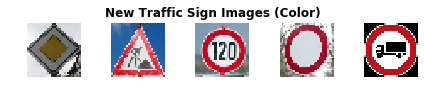

In [149]:
show_image_list(new_imgs, new_img_lbs_text, "New Traffic Sign Images (Color)", cols=len(new_imgs),
               fig_size=(6,6), show_ticks=False)

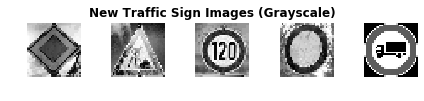

In [150]:
show_image_list(new_imgs_grayscale_clahe, new_img_lbs_text, "New Traffic Sign Images (Grayscale)", 
                cols=len(new_imgs_grayscale_clahe), fig_size=(6,6), show_ticks=False)

The images are chosen because of the following:

   * They represent different traffic signs that we currently classify
   * They vary in shape and color
   * They are under different lighting conditions (the 4th one has sunlight reflection)
   * They are under different orientations (the 3rd one is slanted)
   * They have different background
   * The last image is actually a design, not a real picture, and we wanted to test the model against it to see if it recognizes it
   * Some of them are in under-represented classes
   
## 2. Predicting the Sign Type for Each Image <a name="52"></a>

In [151]:
# First normalise the images
new_img_grayscale_clahe_normalised = normalise_images(new_imgs_grayscale_clahe, X_train_grayscale_equalized)

In [152]:
# Convert to a format Tensorflow understands
new_img_grayscale_clahe_normalised = np.reshape(new_img_grayscale_clahe_normalised, 
                                                (new_img_grayscale_clahe_normalised.shape[0], 32, 32, 1))

In [188]:
# Let's run the predictions now
preds = me_g_augs_clahe_norm_take3_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50.chkpt


In [189]:
preds

array([12, 25,  8, 15, 16])

## 3. Analyze Prediction Performance <a name="53"></a>

### Calculating accuracy <a name="54"></a>

In [190]:
new_img_grayscale_norm_pred_acc = np.sum(new_img_lbs == preds) / len(preds)
print("[Grayscale Normalised] Predictional accuracy on new images: {0}%".format(new_img_grayscale_norm_pred_acc*100))


[Grayscale Normalised] Predictional accuracy on new images: 100.0%


We achieve perfect accuracy of 100% on the new images. On the original test set, we achieved 97.5% accuracy. 

Next we will explore the distribution of our top 5 Softmax probabilites for each image and will plot them.

### Calculating Top 5 Softmax Probabilites <a name="55"></a>

In [177]:
new_img_grayscale_clahe_norm_top5_probs = me_g_augs_clahe_norm_drpt_0_50_3x3.predict(
    new_img_grayscale_clahe_normalised, top_5=True)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50.chkpt


In [178]:
new_img_grayscale_clahe_norm_softmax_lbs_names = list(map(lambda cids: class_ids_to_labels(cids), 
                                                         new_img_grayscale_clahe_norm_top5_probs.indices))

In [179]:
new_img_grayscale_clahe_norm_softmax_and_labels = list(zip(new_img_grayscale_clahe_norm_top5_probs.values,
                                                    new_img_grayscale_clahe_norm_softmax_lbs_names))

In [180]:
# Lets's see the Softmax Probabilities for the first image to have an idea what format look like
new_img_grayscale_clahe_norm_top5_probs.values[0]

array([1.0000000e+00, 6.8846941e-18, 6.6979367e-20, 1.4074748e-22,
       6.1641110e-24], dtype=float32)

In [181]:
# Let'se see the preidcted lables id for the first image
new_img_grayscale_clahe_norm_top5_probs.indices[0]

array([12,  7, 40, 13,  3], dtype=int32)

In [182]:
# And now let's see what our zipped list of softmax probabilities with label names looks like
new_img_grayscale_clahe_norm_softmax_and_labels[0]

(array([1.0000000e+00, 6.8846941e-18, 6.6979367e-20, 1.4074748e-22,
        6.1641110e-24], dtype=float32),
 ['Priority road',
  'Speed limit (100km/h)',
  'Roundabout mandatory',
  'Yield',
  'Speed limit (60km/h)'])

### Visualize Our Softmax Probabilites <a name="56"></a>
We show each new images next to its computed 5 softmax probabilities. The bars in green indicates the ground truth label

In [164]:
def show_imgs_softmax_probs(imgs, softmax_probs_lb_names, correct_lbs, fig_size=(15,7)):
    rows = len(imgs)
    fg, ax = plt.subplots(nrows=rows, ncols=2, figsize=fig_size)
    for i, prob_lb in enumerate(softmax_probs_lb_names):
        correct_lb = correct_lbs[i]
        img = imgs[i]
        ax[i,0].imshow(img)
        ax[i,0].axis("off")
        
        lb_names = prob_lb[1]
        y_pos = np.arange(len(lb_names))
        vals = prob_lb[0]
        for j in range(0, len(lb_names)):
            c = "g" if lb_names[j] == correct_lb else "r"
            ax[i, 1].barh(j, vals[j], color=c, label="{0}".format(lb_names[j]))
            
        ax[i,1].set_yticks(y_pos)
        ax[i,1].set_yticklabels(lb_names)
        ax[i,1].invert_yaxis() # labels read top-on-bottom
        ax[i,1].set_xlabel('Class')
        ax[i,1].set_title('Softmax')
        ax[i,1].set_xscale('log')
        
        ax[i,1].legend(loc='lower right')
        
    fg.tight_layout()
    plt.show()

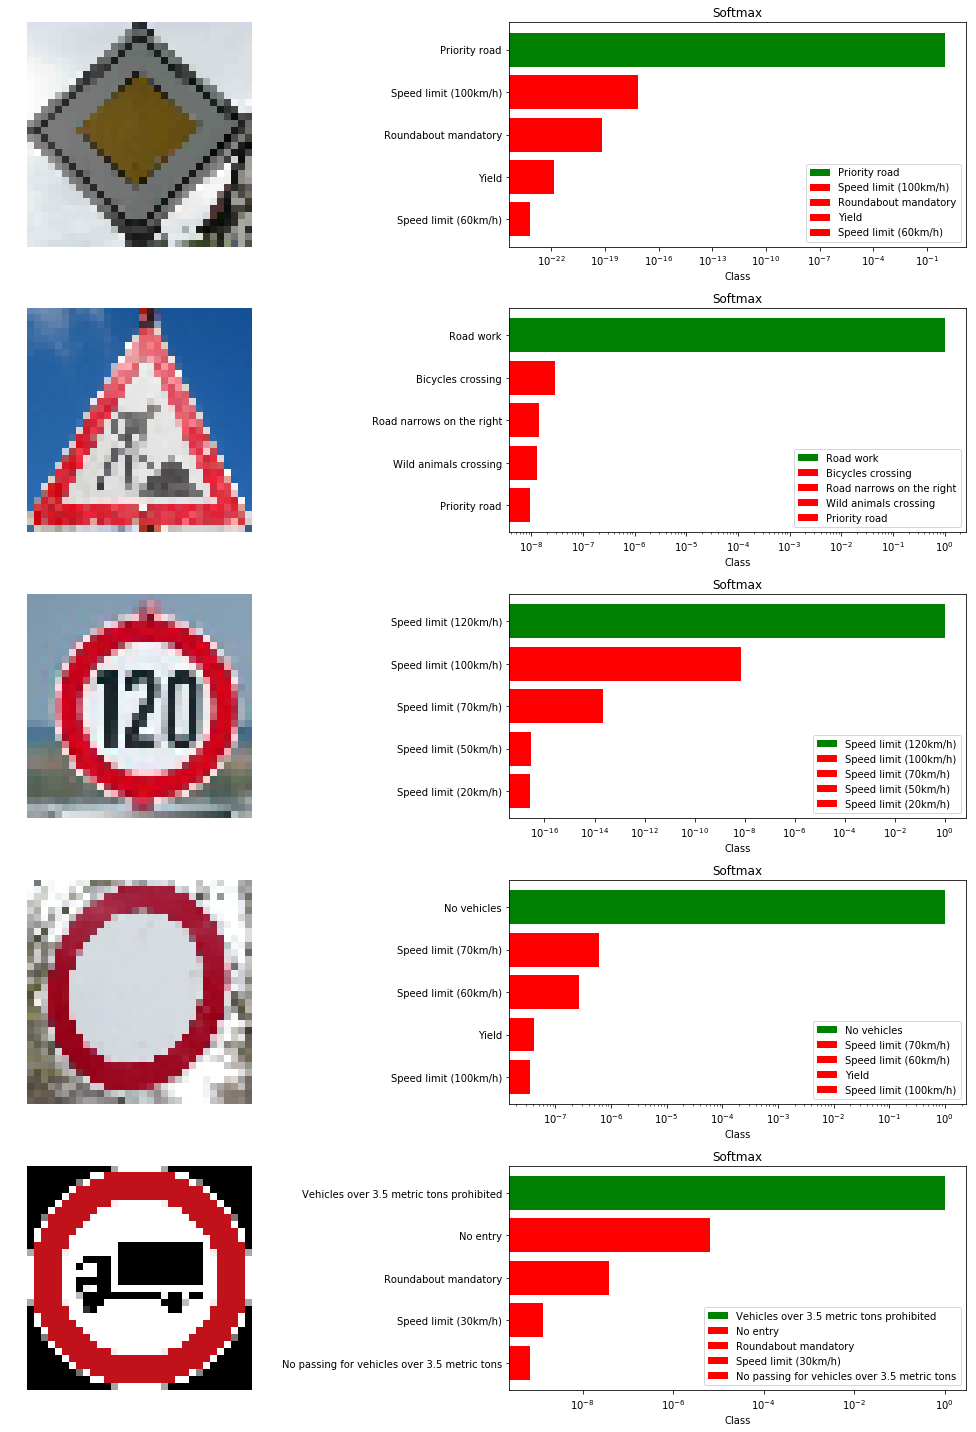

In [183]:
show_imgs_softmax_probs(new_imgs, new_img_grayscale_clahe_norm_softmax_and_labels,
                       new_img_lbs_text, fig_size=(15,20))

We can clearly see that our model quite confident in its predictions. In the worst case, which is the last image, the most likely prediction has a probability of around 10<sup>-5</sup>. This is probably because the image is actually not even a real picture. Overall, we have developed a strong model.

## 4. Visualizing feature maps <a name="57"></a>

While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.


In [191]:
selected_new_img = np.reshape(new_imgs_grayscale_clahe[2], (32, 32, 1))

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50.chkpt
Fetching tensor: EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50/conv_0_relu:0
Shape of activation layer: (1, 30, 30, 32)


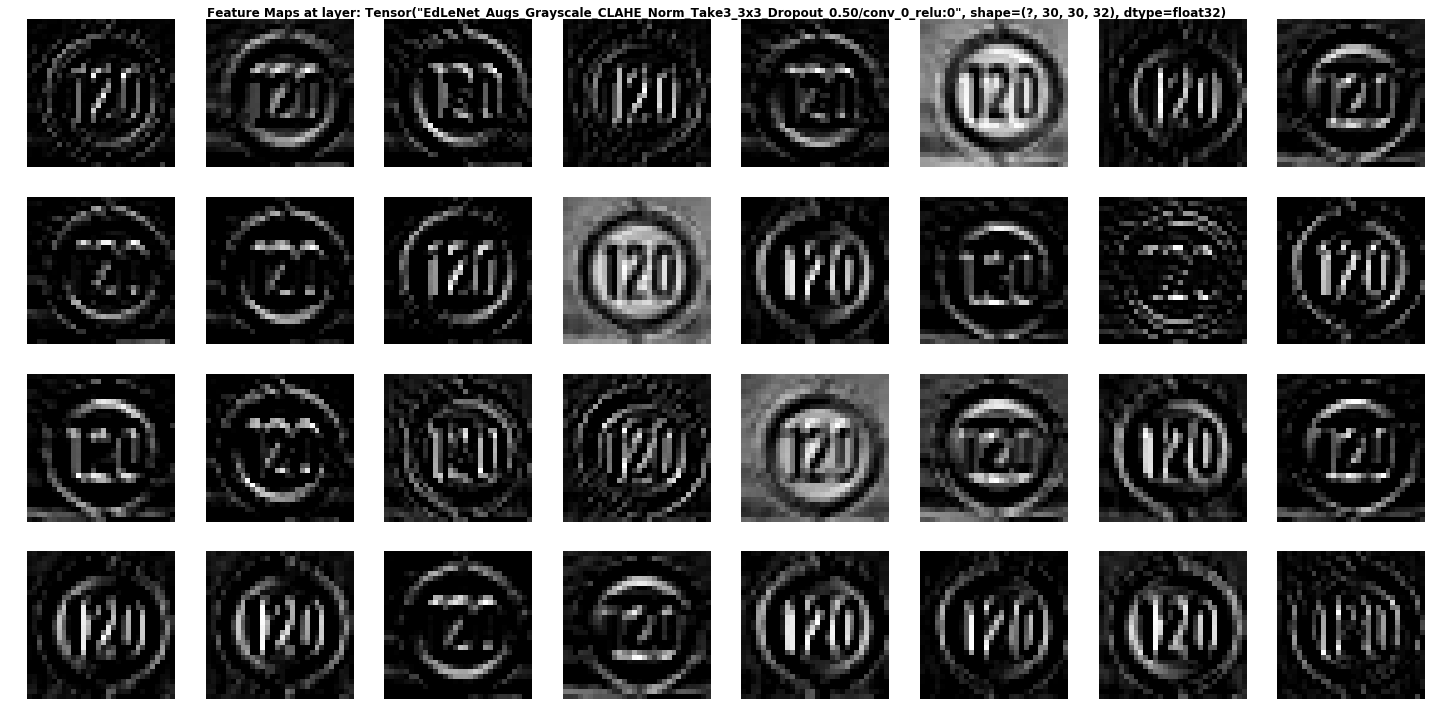

In [192]:
me_g_augs_clahe_norm_take3_drpt_0_50_3x3.show_conv_feature_map(selected_new_img, conv_layer_idx=0, 
                                                           fig_size=(20,10), title_y_pos=1)

We can see that the network is focusing a lot on the edges of the circle and somehow on the 120. The background is ignored.

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50.chkpt
Fetching tensor: EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50/conv_1_relu:0
Shape of activation layer: (1, 13, 13, 64)


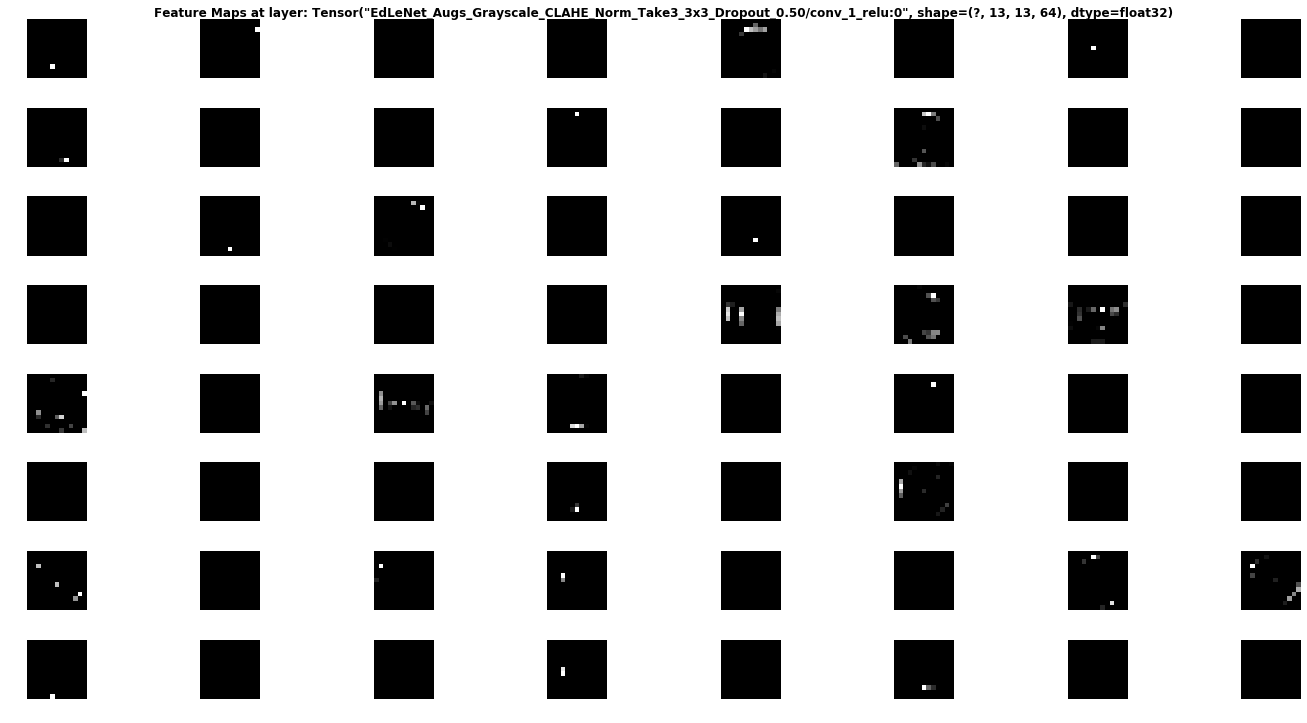

In [193]:
me_g_augs_clahe_norm_take3_drpt_0_50_3x3.show_conv_feature_map(selected_new_img, conv_layer_idx=1, 
                                                           fig_size=(20,10), title_y_pos=1)

It is rather hard to determine what the network is focusing on in layer 1, but it seems to "activate" around the edges of the circle and in the middle, where our 120 is printed.

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50.chkpt
Fetching tensor: EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50/conv_2_relu:0
Shape of activation layer: (1, 4, 4, 128)


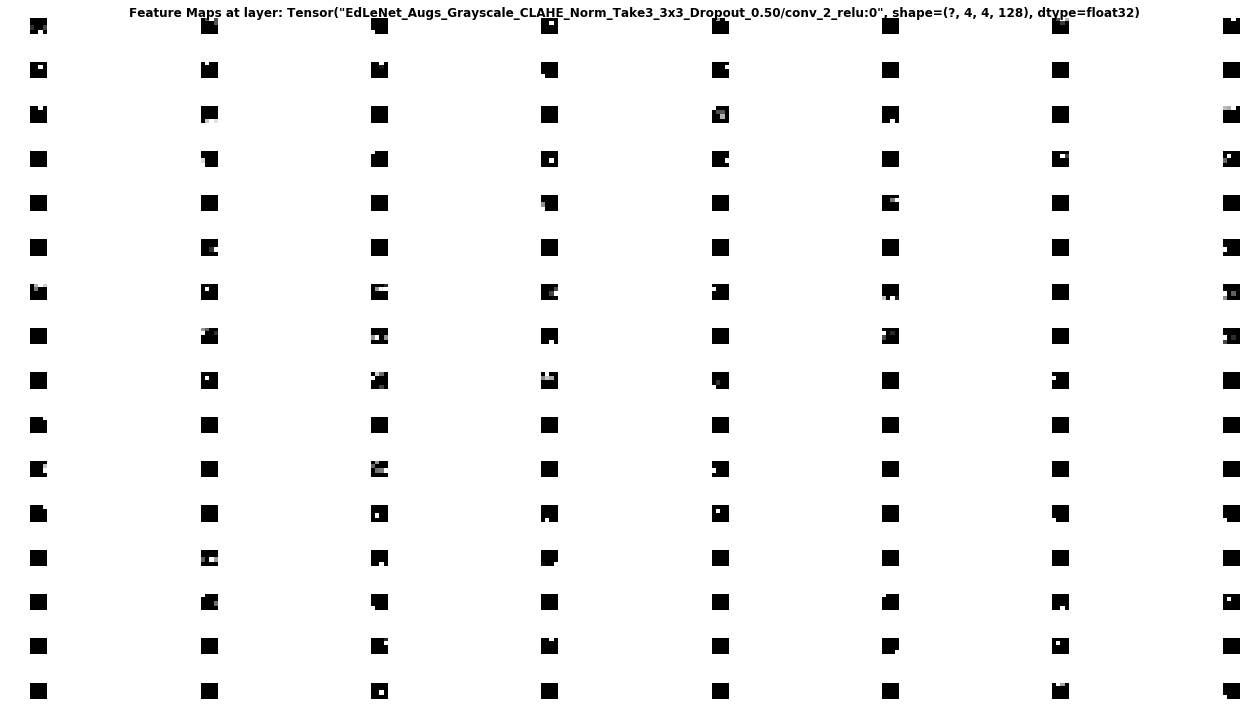

In [194]:
me_g_augs_clahe_norm_take3_drpt_0_50_3x3.show_conv_feature_map(selected_new_img, conv_layer_idx=2, 
                                                           fig_size=(20,10), title_y_pos=1)

This activation map is also hard to decipher... But it seems the network reacts to stimuli on the edges and in the middle once again.

## 5. Future Improvement <a name="58"></a>

While we have obtained very good results, we believe that we can achieve even better performance in the future by testing more hyperparameter variations (e.g. dimensions of fully connected layers) as well as exploring novel ANN architectures such as GoogLeNet's Inception Module, Resnet, or Xception. 